***
<font size="6"><center><b> HD-CapsNet: A Hierarchical Deep Capsule Network for Image Classification </b></center></font>
***

**Changing Model Architecture**
- **(Mod-3.1)** 32D>16D>8D (Coarse>Medium>FINE) use skip connections between Secondary Capsules $Concatenate([P_{caps}, S_{coarse}])$ > input for $S_{medium}$ and $Concatenate([P_{caps}, S_{medium}])$ > input for $S_{fine}$
- With $L_{Cons}$

# Files and Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras import backend as K

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

# Supporting Libraries:
    #Mathplot lib for ploting graphs
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
    # numpy and pandas
import numpy as np
import pandas as pd
    #system
import os
import sys
import csv
    #import other libraries
import math
import random
from datetime import datetime
from treelib import Tree
    # ML model, Dataset and evalution metrics
sys.path.append('../../') ### adding system parth for src folder
from src import datasets # load datasets
from src import MixUp_add_loss # load datasets
from src import metrics # load hierarchcial metrics
from src import sysenv # load hierarchcial metrics
from src import models # load machine learning models

    ## Tensorflow_docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

    # Auto reload local libraries if updated
%load_ext autoreload
%autoreload 2

# System information & GPU growth

In [2]:
systeminfo = sysenv.systeminfo()
print(systeminfo)


• Computer Name = 30BFPC1AXW95
• Working Directory = C:\Users\knoor\OneDrive - Deakin University\Deep Learning with Python\Google_Drive\Projects\Deep Learning\HD-CapsNet\Training_and_Analysis\3_CIFAR-10
• Python Version = 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
• TensorFlow Version = 2.8.0
• Keras Version = 2.8.0
• Current Environment = Anaconda Environment Name : py38tf


In [3]:
gpus = "0,1,2,3,4,5,6,7" ## Selecting Available gpus (Multi-GPUS)
gpus = "0" ## Selecting Available gpus (Single GPU)
gpugrowth = sysenv.gpugrowth(gpus = gpus) ## Limiting GPUS from OS environment
gpugrowth.memory_growth() #GPU memory growth

Following GPUS are selected =  0
Done: GPU PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


## log directory

In [4]:
HDCapsNet_directory = sysenv.log_dir('3_CIFAR_10/HD_CapsNet/Mod_3_3')
BCNN_directory = sysenv.log_dir('3_CIFAR_10/BCNN')


# Import Dataset : CIFAR-10

In [5]:
dataset = datasets.CIFAR10(version = 'ALL') # importing CIFAR10 Dataset
# dataset = datasets.CIFAR10(version = 'reduce') # importing CIFAR10 Dataset

CIFAR-10 dataset: Training have 50,000 samples and testing have 10,000 samples


# Parameters

In [6]:
train_params = {"n_epochs" : 100,
                "batch_size": 64,
                "lr": 0.001, # Initial learning rate
                "lr_decay": 0.95, # Learning rate decay
                "decay_exe": 9, #learning rate decay execution epoch after
               }
model_params = {"optimizer": tf.keras.optimizers.Adam(train_params['lr']),
                "loss_function": models.MarginLoss(),
               }

## Learning Rate Decay Scheduler

In [7]:
def scheduler(epoch):
    learning_rate_init = train_params["lr"]
    
    if epoch > train_params["decay_exe"]:
        learning_rate_init = train_params["lr"] * (train_params["lr_decay"] ** (epoch-9))
        
    tf.summary.scalar('learning rate', data=learning_rate_init, step=epoch)
        
    return learning_rate_init

# Model Analysis

## Loss Function

In [8]:
number_of_classes_c = len(np.unique(np.argmax(dataset['y_train_coarse'], axis=1)))
number_of_classes_m = len(np.unique(np.argmax(dataset['y_train_medium'], axis=1)))
number_of_classes_f = len(np.unique(np.argmax(dataset['y_train_fine'], axis=1)))

## For Dynamic LossWeights
initial_lw = models.initial_lw({"coarse": number_of_classes_c,
                                "medium": number_of_classes_m,
                                "fine": number_of_classes_f})

lossweight = {'coarse_lw' : K.variable(value = initial_lw['coarse'], dtype="float32", name="coarse_lw"),
             'medium_lw' : K.variable(value = initial_lw['medium'], dtype="float32", name="medium_lw"),
             'fine_lw' : K.variable(value = initial_lw['fine'], dtype="float32", name="fine_lw"),
              'decoder_lw' : 0.0
             }

In [9]:
coarse_to_medium_array = np.zeros(shape=[number_of_classes_c,number_of_classes_m], dtype=np.int32)
medium_to_fine_array = np.zeros(shape=[number_of_classes_m,number_of_classes_f], dtype=np.int32)

c_id = np.argmax(dataset['y_train_coarse'],1)

m_id = np.argmax(dataset['y_train_medium'],1)

f_id = np.argmax(dataset['y_train_fine'],1)

for x in range(len(dataset['y_test_medium'])):
    coarse_to_medium_array[c_id[x]][m_id[x]] = 1
    
for x in range(len(dataset['y_test_fine'])):
    medium_to_fine_array[m_id[x]][f_id[x]] = 1

Matrix_coarse_to_medium_OneHot = tf.constant(coarse_to_medium_array, dtype=tf.float32)
Matrix_medium_to_fine_OneHot = tf.constant(medium_to_fine_array, dtype=tf.float32)

In [10]:
def margin_loss(y_true, y_proba):
    
    present_error_raw = tf.square(tf.maximum(0., 0.9 - y_proba), name="present_error_raw")
    absent_error_raw = tf.square(tf.maximum(0., y_proba - 0.1), name="absent_error_raw")
    L = tf.add(y_true * present_error_raw, 0.5 * (1.0 - y_true) * absent_error_raw,name="L")
    total_marginloss = tf.reduce_sum(L, axis=1, name="margin_loss")

    return total_marginloss


def consistency_check(y_pred_ancestor,y_pred_current,lookup_matrix,num_class_current):
    pred_max_ancestor = tf.argmax(y_pred_ancestor,axis=1)
    pred_max_current = tf.argmax(y_pred_current,axis=1)
    
    consistant_check = tf.gather(lookup_matrix, indices=pred_max_ancestor)*tf.one_hot(pred_max_current,num_class_current)
    
    return tf.reduce_sum(consistant_check,1)

def get_consistency(y_true_ancestor, y_pred, lookup_matrix):
    '''
    Get consistency based on 2 levels
    Provide ture levels for the level above, predictions for the current level and a look up metrix
    '''
    y_prob = tf.math.divide(y_pred,tf.reshape(tf.reduce_sum(y_pred,-1),(-1,1),name='reshape'),name='Probability')
    
    index_for_predictions = tf.cast(tf.math.argmax(y_true_ancestor,axis=1),dtype= 'int32')
    consistent_fine = tf.gather(lookup_matrix, indices=index_for_predictions) * y_prob
    Consistency_sum_array = tf.reduce_sum(consistent_fine, axis =1)
    
    return tf.abs(1-Consistency_sum_array)

def CustomLoss(y_true_c, y_true_m, y_true_f, y_pred_c, y_pred_m, y_pred_f, LW_C, LW_M, LW_F,tree: Tree,C_Weight=0.2):
    
    con_m = consistency_check(y_pred_c,y_pred_m,Matrix_coarse_to_medium_OneHot,num_class_current=7)
    con_m_not = tf.abs(con_m-1)
    
    con_f = consistency_check(y_pred_m,y_pred_f,Matrix_medium_to_fine_OneHot,num_class_current=10)
    con_f_not = tf.abs(con_f-1)
    
    con_sum_m = get_consistency(y_true_c,y_pred_m,Matrix_coarse_to_medium_OneHot)
    con_sum_f = get_consistency(y_true_m,y_pred_f,Matrix_medium_to_fine_OneHot)
    
    medium_lvl_cosistency = con_sum_m * con_m_not
    fine_lvl_cosistency = con_sum_f * con_f_not    
   
    ML_c = margin_loss(y_true_c, y_pred_c)*LW_C
    ML_m = LW_M*((1-C_Weight)*(margin_loss(y_true_m, y_pred_m))+C_Weight*(medium_lvl_cosistency))
    ML_f = LW_F*((1-C_Weight)*(margin_loss(y_true_f, y_pred_f))+C_Weight*(fine_lvl_cosistency))
    
    batch_loss = ML_c + ML_m+ ML_f

    return tf.reduce_mean(batch_loss)

## Model Architecture

In [11]:
def get_compiled_HDCapsNet_model():
    
    ## Calling the HD-CapsNet Model
    model = models.HD_CapsNet_Mod_3_3(input_shape     = dataset['x_train'].shape[1:], 
                                      input_shape_yc  = dataset['y_train_coarse'].shape[1:],
                                      input_shape_ym  = dataset['y_train_medium'].shape[1:],
                                      input_shape_yf  = dataset['y_train_fine'].shape[1:], 
                                      no_coarse_class = number_of_classes_c, 
                                      no_medium_class = number_of_classes_m, 
                                      no_fine_class   = number_of_classes_f,
                                      PCap_n_dims     = 8, 
                                      SCap_f_dims     = 16, 
                                      SCap_m_dims     = 32, 
                                      SCap_c_dims     = 64)
    
    ## Saving Model Architecture
#     keras.utils.plot_model(model, to_file = directory+"/Architecture.png", show_shapes=True)
    
    ## Add Loss for Model
    model.add_loss(CustomLoss(y_true_c            = model.inputs[1], 
                              y_true_m            = model.inputs[2], 
                              y_true_f            = model.inputs[3], 
                              y_pred_c            = model.output[0], 
                              y_pred_m            = model.output[1], 
                              y_pred_f            = model.output[2], 
                              LW_C                = lossweight['coarse_lw'], 
                              LW_M                = lossweight['medium_lw'], 
                              LW_F                = lossweight['fine_lw'],
                              tree                = dataset['tree'], 
                              C_Weight            =0.2)
                  )
    
    ## Compile Model
    model.compile(optimizer='adam',                  
                  metrics={'prediction_fine': 'accuracy',
                           'prediction_medium': 'accuracy',
                           'prediction_coarse': 'accuracy'}
                 )
    return model

def get_compiled_BCNN_model():
    model = models.B_CNN_Model_B(input_shape     = dataset['x_train'].shape[1:],
                                 num_class_c = number_of_classes_c,
                                 num_class_m = number_of_classes_m,
                                 num_class_f   = number_of_classes_f)
    sgd = optimizers.SGD(lr=0.003, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', 
                  optimizer=sgd,
                  metrics=['accuracy'])
    return model


In [12]:
HDCapsNet_model = get_compiled_HDCapsNet_model()
BCNN_model = get_compiled_BCNN_model()

C:\Users\knoor\.conda\envs\py38tf\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [13]:
HDCapsNet_model.summary()

Model: "HD-CapsNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Image (InputLayer)       [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 32, 32, 64)   1792        ['Input_Image[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['block1_conv1[0][0]']           
 alization)                                                                                       
                                                                                                  
 block1_conv2 (Conv2D)          (None, 32, 32, 64)   36928       ['batch_normalization[0]

                                                                                                  
 prediction_medium (LengthLayer  (None, 7)           0           ['s_caps_medium[0][0]']          
 )                                                                                                
                                                                                                  
 prediction_fine (LengthLayer)  (None, 10)           0           ['s_caps_fine[0][0]']            
                                                                                                  
 tf.math.argmax_4 (TFOpLambda)  (None,)              0           ['input_yc[0][0]']               
                                                                                                  
 tf.math.reduce_sum_2 (TFOpLamb  (None,)             0           ['prediction_medium[0][0]']      
 da)                                                                                              
          

 )                                                                                                
                                                                                                  
 tf.math.square_2 (TFOpLambda)  (None, 7)            0           ['tf.math.maximum_2[0][0]']      
                                                                                                  
 tf.math.multiply_11 (TFOpLambd  (None, 7)           0           ['tf.math.subtract_9[0][0]']     
 a)                                                                                               
                                                                                                  
 tf.math.square_3 (TFOpLambda)  (None, 7)            0           ['tf.math.maximum_3[0][0]']      
                                                                                                  
 tf.math.reduce_sum_3 (TFOpLamb  (None,)             0           ['tf.math.multiply_2[0][0]']     
 da)      

 )                                                                                                
                                                                                                  
 tf.math.multiply_6 (TFOpLambda  (None, 2)           0           ['input_yc[0][0]',               
 )                                                                'tf.math.square[0][0]']         
                                                                                                  
 tf.math.multiply_8 (TFOpLambda  (None, 2)           0           ['tf.math.multiply_7[0][0]',     
 )                                                                'tf.math.square_1[0][0]']       
                                                                                                  
 tf.math.reduce_sum_7 (TFOpLamb  (None,)             0           ['tf.math.add_1[0][0]']          
 da)                                                                                              
          

In [14]:
BCNN_model.summary()

Model: "B_CNN_Model_B"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 32, 32, 64)   1792        ['input[0][0]']                  
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 32, 32, 64)  256         ['block1_conv1[0][0]']           
 rmalization)                                                                                     
                                                                                                  
 block1_conv2 (Conv2D)          (None, 32, 32, 64)   36928       ['batch_normalization

                                                                                                  
 f_fc2_2 (Dense)                (None, 1024)         1049600     ['dropout_4[0][0]']              
                                                                                                  
 batch_normalization_13 (BatchN  (None, 256)         1024        ['c_fc_2[0][0]']                 
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_17 (BatchN  (None, 512)         2048        ['m_fc_2[0][0]']                 
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_21 (BatchN  (None, 1024)        4096        ['f_fc2_2[0][0]']                
 ormalizat

## Model Training

In [15]:
HDCapsNet_Weight = str(HDCapsNet_directory+'/trained_model.h5')
BCNN_Weight = str(BCNN_directory+'/trained_model.h5')

HDCapsNet_model.load_weights(HDCapsNet_Weight)
BCNN_model.load_weights(BCNN_Weight)


## Model Analysis

In [16]:
HDCapsNet_model = keras.Model(HDCapsNet_model.inputs[:1], HDCapsNet_model.output)

lossfn = models.MarginLoss()
HDCapsNet_model.compile(optimizer='adam', 
                    loss={'prediction_fine' : lossfn,
                          'prediction_medium' : lossfn,
                          'prediction_coarse' : lossfn},

                    loss_weights={'prediction_fine' : lossweight['fine_lw'],
                                  'prediction_medium' : lossweight['medium_lw'],
                                  'prediction_coarse' : lossweight['coarse_lw']},

                    metrics={'prediction_fine': 'accuracy',
                             'prediction_medium': 'accuracy',
                             'prediction_coarse': 'accuracy'
                            }
                   )

## HD-CapsNet

313/313 [==============================] - 12s 16ms/step - loss: 1.4103 - c_predictions_loss: 0.1062 - m_predictions_loss: 0.4656 - f_predictions_loss: 0.8385 - c_predictions_accuracy: 0.9608 - m_predictions_accuracy: 0.8713 - f_predictions_accuracy: 0.8454
1. loss ==> 1.4103384017944336
2. c_predictions_loss ==> 0.10623360425233841
3. m_predictions_loss ==> 0.46563485264778137
4. f_predictions_loss ==> 0.8384688496589661
5. c_predictions_accuracy ==> 0.9607999920845032
6. m_predictions_accuracy ==> 0.8712999820709229
7. f_predictions_accuracy ==> 0.8453999757766724
313/313 [==============================] - 3s 10ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

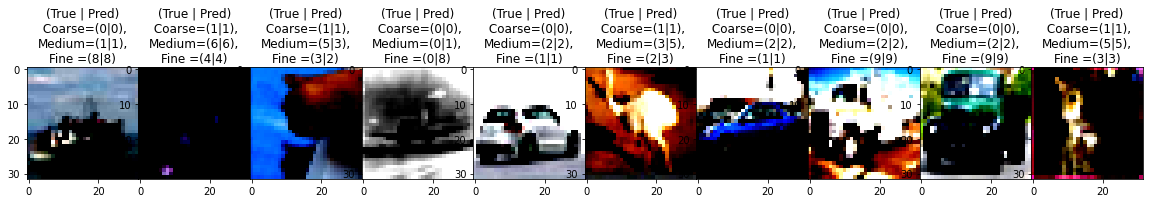

In [17]:
model_analysis = models.model_analysis(BCNN_model, dataset)
BCNN_results = model_analysis.evaluate()
BCNN_predictions = model_analysis.prediction()

313/313 [==============================] - 7s 20ms/step - loss: 0.0342 - prediction_coarse_loss: 0.0096 - prediction_medium_loss: 0.0447 - prediction_fine_loss: 0.0667 - prediction_coarse_accuracy: 0.9882 - prediction_medium_accuracy: 0.9396 - prediction_fine_accuracy: 0.9126
1. loss ==> 0.03421856462955475
2. prediction_coarse_loss ==> 0.009629051201045513
3. prediction_medium_loss ==> 0.04470864683389664
4. prediction_fine_loss ==> 0.06667865067720413
5. prediction_coarse_accuracy ==> 0.9882000088691711
6. prediction_medium_accuracy ==> 0.9395999908447266
7. prediction_fine_accuracy ==> 0.9125999808311462
313/313 [==============================] - 4s 10ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

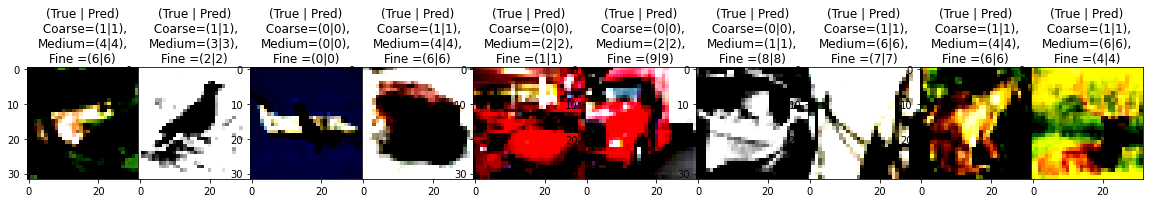

In [18]:
model_analysis = models.model_analysis(HDCapsNet_model, dataset)
HDCapsNet_results = model_analysis.evaluate()
HDCapsNet_predictions = model_analysis.prediction()

In [19]:
true_label = [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]
h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,
                                       BCNN_predictions,
                                       dataset['tree'])
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )


Hierarchical Precision = 0.8926 
Hierarchical Recall = 0.9147666666666668 
Hierarchical F1-Score = 0.901782142857143 
Consistency =  0.8972 
Exact Match =  0.7899


In [20]:
true_label = [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]
h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,
                                       HDCapsNet_predictions,
                                       dataset['tree'])
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )


Hierarchical Precision = 0.9464816666666668 
Hierarchical Recall = 0.9481666666666666 
Hierarchical F1-Score = 0.9471916666666667 
Consistency =  0.9911 
Exact Match =  0.909


# Not consistent

In [41]:
def get_model_consistency(y_pred: list, tree: Tree):
    """
    This methods estimates the consistency.

    :param y_pred: a 2d array where d1 is the taxonomy level, and d2 is the prediction for each example.
    :type y_pred: np.array
    :param tree: A tree of the taxonomy.
    :type tree: Tree
    :return: value of consistency.
    :rtype: float
    """
    y_pred = [np.argmax(x, axis=1) for x in y_pred]
    consistency = []
    not_consistent = {}
    for j in range(len(y_pred[0])):
        v = 1
        for i in range(len(y_pred) - 1):
            parent = 'L' + str(i) + '_' + str(y_pred[i][j])
            child = 'L' + str(i + 1) + '_' + str(y_pred[i + 1][j])
            if tree.parent(child).identifier != parent:
                v = 0
                break
        consistency.append(v)
    return consistency

In [54]:
range(len(y_pred) - 1)

range(0, 2)

In [50]:
y_pred = [np.argmax(x, axis=1) for x in BCNN_predictions]
for j in range(len(y_pred[0])):
    v = 1
    for i in range(len(y_pred) - 1):
        parent = 'L' + str(i) + '_' + str(y_pred[i][j])
        child = 'L' + str(i + 1) + '_' + str(y_pred[i + 1][j])
        if dataset['tree'].parent(child).identifier != parent:
            v = 0
        print(parent,'C=',child, 'v=', v)

L0_1 C= L1_5 v= 1
L1_5 C= L2_3 v= 1
L0_0 C= L1_1 v= 1
L1_1 C= L2_8 v= 1
L0_0 C= L1_1 v= 1
L1_1 C= L2_8 v= 1
L0_0 C= L1_0 v= 1
L1_0 C= L2_0 v= 1
L0_1 C= L1_4 v= 1
L1_4 C= L2_6 v= 1
L0_1 C= L1_4 v= 1
L1_4 C= L2_6 v= 1
L0_0 C= L1_5 v= 0
L1_5 C= L2_1 v= 0
L0_1 C= L1_4 v= 1
L1_4 C= L2_6 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_3 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_1 v= 1
L0_0 C= L1_0 v= 1
L1_0 C= L2_0 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_5 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_7 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_0 C= L1_1 v= 1
L1_1 C= L2_8 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_5 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_7 v= 1
L0_0 C= L1_1 v= 1
L1_1 C= L2_8 v= 1
L0_1 C= L1_4 v= 1
L1_4 C= L2_6 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_7 v= 1
L0_0 C= L1_0 v= 1
L1_0 C= L2_0 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_4 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_4 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_2 v= 0
L0_1 C= L1_5 v= 1
L1_5 C= L2_3 v= 1
L0_1 C= L1_0 v= 0
L1_0 C= L2

L1_4 C= L2_6 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_3 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_5 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_3 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_7 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_3 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_7 v= 1
L0_1 C= L1_3 v= 1
L1_3 C= L2_2 v= 1
L0_1 C= L1_3 v= 1
L1_3 C= L2_2 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_3 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_1 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_4 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_5 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_7 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_5 v= 1
L0_0 C= L1_0 v= 1
L1_0 C= L2_0 v= 1
L0_1 C= L1_3 v= 1
L1_3 C= L2_2 v= 1
L0_1 C= L1_0 v= 0
L1_0 C= L2_2 v= 0
L0_1 C= L1_3 v= 1
L1_3 C= L2_2 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_7 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_3 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_4 v= 0
L0_1 C= L1_6 v= 1
L1_6 C= L2_4 v= 1
L0_1 C= L1

L1_6 C= L2_7 v= 1
L0_0 C= L1_0 v= 1
L1_0 C= L2_0 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_7 v= 1
L0_1 C= L1_3 v= 1
L1_3 C= L2_2 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_1 v= 1
L0_1 C= L1_0 v= 0
L1_0 C= L2_0 v= 0
L0_1 C= L1_3 v= 1
L1_3 C= L2_2 v= 1
L0_0 C= L1_0 v= 1
L1_0 C= L2_0 v= 1
L0_1 C= L1_3 v= 1
L1_3 C= L2_2 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_4 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_7 v= 0
L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_0 C= L1_1 v= 1
L1_1 C= L2_8 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_1 v= 1
L0_0 C= L1_0 v= 1
L1_0 C= L2_0 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_7 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_7 v= 1
L0_0 C= L1_0 v= 1
L1_0 C= L2_0 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_7 v= 1
L0_0 C= L1_1 v= 1
L1_1 C= L2_8 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_4 v= 1
L0_1 C= L1_4 v= 1
L1_4 C= L2_6 v= 1
L0_1 C= L1_3 v= 1
L1_3 C= L2_3 v= 0
L0_1 C= L1_5 v= 1
L1_5 C= L2_3 v= 1
L0_0 C= L1_0 v= 1
L1_0 C= L2_0 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_1 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_3 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_7 v= 1
L0_0 C= L1

L0_1 C= L1_6 v= 1
L1_6 C= L2_7 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_1 v= 1
L0_0 C= L1_1 v= 1
L1_1 C= L2_8 v= 1
L0_0 C= L1_1 v= 1
L1_1 C= L2_8 v= 1
L0_0 C= L1_0 v= 1
L1_0 C= L2_0 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_7 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_5 v= 1
L0_0 C= L1_1 v= 1
L1_1 C= L2_8 v= 1
L0_0 C= L1_0 v= 1
L1_0 C= L2_0 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_3 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_3 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_3 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_7 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_7 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_7 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_3 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_1 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_1 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_1 v= 1
L0_1 C= L1_4 v= 1
L1_4 C= L2_6 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_3 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_3 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_3 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_1 v= 1
L0_0 C= L1_0 v= 1
L1_0 C= L2_0 v= 1
L0_1 C= L1_4 v= 1
L1_4 C= L2

L1_5 C= L2_3 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_4 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_3 v= 1
L0_1 C= L1_3 v= 1
L1_3 C= L2_2 v= 1
L0_0 C= L1_1 v= 1
L1_1 C= L2_8 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_4 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_5 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_5 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_4 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_1 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_4 v= 1
L0_0 C= L1_3 v= 0
L1_3 C= L2_2 v= 0
L0_1 C= L1_5 v= 1
L1_5 C= L2_5 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_1 C= L1_4 v= 1
L1_4 C= L2_6 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_4 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_3 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_4 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_4 v= 1
L0_0 C= L1_0 v= 1
L1_0 C= L2_0 v= 1
L0_0 C= L1_1 v= 1
L1_1 C= L2_8 v= 1
L0_0 C= L1_1 v= 1
L1_1 C= L2_8 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_4 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_5 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_7 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_5 v= 1
L0_1 C= L1_4 v= 1
L1_4 C= L2_6 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_0 C= L1

L0_1 C= L1_0 v= 0
L1_0 C= L2_0 v= 0
L0_0 C= L1_0 v= 1
L1_0 C= L2_0 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_1 v= 1
L0_1 C= L1_4 v= 1
L1_4 C= L2_6 v= 1
L0_0 C= L1_6 v= 0
L1_6 C= L2_9 v= 0
L0_0 C= L1_2 v= 1
L1_2 C= L2_1 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_5 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_4 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_4 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_4 v= 1
L0_0 C= L1_0 v= 1
L1_0 C= L2_0 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_1 C= L1_2 v= 0
L1_2 C= L2_9 v= 0
L0_0 C= L1_1 v= 1
L1_1 C= L2_8 v= 1
L0_1 C= L1_3 v= 1
L1_3 C= L2_2 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_4 v= 1
L0_1 C= L1_3 v= 1
L1_3 C= L2_2 v= 1
L0_1 C= L1_3 v= 1
L1_3 C= L2_2 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_5 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_1 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_3 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_1 v= 1
L0_0 C= L1_0 v= 1
L1_0 C= L2_0 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_4 v= 1
L0_1 C= L1_3 v= 1
L1_3 C= L2

L1_4 C= L2_6 v= 1
L0_0 C= L1_0 v= 1
L1_0 C= L2_0 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_1 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_1 v= 1
L0_0 C= L1_1 v= 1
L1_1 C= L2_8 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_4 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_5 v= 1
L0_1 C= L1_2 v= 0
L1_2 C= L2_5 v= 0
L0_0 C= L1_2 v= 1
L1_2 C= L2_1 v= 1
L0_1 C= L1_3 v= 1
L1_3 C= L2_2 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_4 v= 1
L0_0 C= L1_1 v= 1
L1_1 C= L2_8 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_0 C= L1_1 v= 1
L1_1 C= L2_8 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_1 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_7 v= 0
L0_1 C= L1_3 v= 1
L1_3 C= L2_2 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_7 v= 1
L0_1 C= L1_0 v= 0
L1_0 C= L2_2 v= 0
L0_1 C= L1_5 v= 1
L1_5 C= L2_3 v= 1
L0_1 C= L1_4 v= 1
L1_4 C= L2_1 v= 0
L0_1 C= L1_4 v= 1
L1_4 C= L2_6 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_7 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_4 v= 1
L0_0 C= L1_0 v= 1
L1_0 C= L2_0 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_1 v= 1
L0_0 C= L1_0 v= 1
L1_0 C= L2_0 v= 1
L0_1 C= L1

L1_3 C= L2_2 v= 1
L0_0 C= L1_0 v= 1
L1_0 C= L2_0 v= 1
L0_0 C= L1_1 v= 1
L1_1 C= L2_8 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_3 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_1 C= L1_3 v= 1
L1_3 C= L2_2 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_3 v= 1
L0_1 C= L1_4 v= 1
L1_4 C= L2_6 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_5 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_7 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_4 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_7 v= 1
L0_1 C= L1_3 v= 1
L1_3 C= L2_2 v= 1
L0_0 C= L1_1 v= 1
L1_1 C= L2_8 v= 1
L0_0 C= L1_0 v= 1
L1_0 C= L2_8 v= 0
L0_1 C= L1_6 v= 1
L1_6 C= L2_4 v= 1
L0_1 C= L1_3 v= 1
L1_3 C= L2_2 v= 1
L0_1 C= L1_2 v= 0
L1_2 C= L2_1 v= 0
L0_1 C= L1_4 v= 1
L1_4 C= L2_6 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_2 v= 0
L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_0 C= L1_1 v= 1
L1_1 C= L2_8 v= 1
L0_1 C= L1_3 v= 1
L1_3 C= L2_2 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_3 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_1 v= 1
L0_0 C= L1_0 v= 1
L1_0 C= L2_0 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_5 v= 1
L0_1 C= L1

L0_0 C= L1_1 v= 1
L1_1 C= L2_8 v= 1
L0_0 C= L1_3 v= 0
L1_3 C= L2_2 v= 0
L0_0 C= L1_1 v= 1
L1_1 C= L2_8 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_5 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_3 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_1 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_6 v= 0
L0_1 C= L1_3 v= 1
L1_3 C= L2_2 v= 1
L0_0 C= L1_0 v= 1
L1_0 C= L2_0 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_1 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_0 C= L1_1 v= 1
L1_1 C= L2_8 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_1 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_1 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_0 v= 0
L0_0 C= L1_1 v= 1
L1_1 C= L2_8 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_0 C= L1_5 v= 0
L1_5 C= L2_8 v= 0
L0_1 C= L1_3 v= 1
L1_3 C= L2_2 v= 1
L0_1 C= L1_4 v= 1
L1_4 C= L2_6 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_1 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_0 C= L1_3 v= 0
L1_3 C= L2_2 v= 0
L0_0 C= L1_2 v= 1
L1_2 C= L2

L1_4 C= L2_6 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_1 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_4 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_5 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_0 C= L1_0 v= 1
L1_0 C= L2_0 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_1 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_4 v= 1
L0_0 C= L1_0 v= 1
L1_0 C= L2_0 v= 1
L0_0 C= L1_1 v= 1
L1_1 C= L2_8 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_1 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_1 v= 1
L0_1 C= L1_4 v= 1
L1_4 C= L2_6 v= 1
L0_1 C= L1_4 v= 1
L1_4 C= L2_6 v= 1
L0_0 C= L1_4 v= 0
L1_4 C= L2_8 v= 0
L0_1 C= L1_5 v= 1
L1_5 C= L2_5 v= 1
L0_1 C= L1_3 v= 1
L1_3 C= L2_2 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_7 v= 0
L0_0 C= L1_1 v= 1
L1_1 C= L2_8 v= 1
L0_1 C= L1_4 v= 1
L1_4 C= L2_6 v= 1
L0_0 C= L1_0 v= 1
L1_0 C= L2_9 v= 0
L0_0 C= L1_2 v= 1
L1_2 C= L2_1 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_7 v= 1
L0_1 C= L1_4 v= 1
L1_4 C= L2_6 v= 1
L0_0 C= L1_0 v= 1
L1_0 C= L2_0 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_5 v= 1
L0_1 C= L1

L1_5 C= L2_5 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_1 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_0 C= L1_0 v= 1
L1_0 C= L2_0 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_3 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_3 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_1 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_5 v= 1
L0_1 C= L1_4 v= 1
L1_4 C= L2_6 v= 1
L0_1 C= L1_4 v= 1
L1_4 C= L2_6 v= 1
L0_1 C= L1_3 v= 1
L1_3 C= L2_2 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_4 v= 1
L0_1 C= L1_4 v= 1
L1_4 C= L2_6 v= 1
L0_0 C= L1_1 v= 1
L1_1 C= L2_8 v= 1
L0_0 C= L1_1 v= 1
L1_1 C= L2_8 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_6 v= 0
L0_1 C= L1_4 v= 1
L1_4 C= L2_6 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_1 v= 1
L0_0 C= L1_0 v= 1
L1_0 C= L2_0 v= 1
L0_0 C= L1_6 v= 0
L1_6 C= L2_7 v= 0
L0_1 C= L1_5 v= 1
L1_5 C= L2_5 v= 1
L0_0 C= L1_1 v= 1
L1_1 C= L2_8 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_2 v= 0
L0_0 C= L1_2 v= 1
L1_2 C= L2_1 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_3 v= 1
L0_0 C= L1_1 v= 1
L1_1 C= L2_8 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_1 v= 1
L0_1 C= L1

L0_1 C= L1_5 v= 1
L1_5 C= L2_5 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_4 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_5 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_1 C= L1_4 v= 1
L1_4 C= L2_6 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_7 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_1 v= 1
L0_0 C= L1_0 v= 1
L1_0 C= L2_0 v= 1
L0_1 C= L1_4 v= 1
L1_4 C= L2_4 v= 0
L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_4 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_7 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_7 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_3 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_1 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_7 v= 1
L0_0 C= L1_0 v= 1
L1_0 C= L2_0 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_1 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_3 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_5 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_4 v= 1
L0_1 C= L1_4 v= 1
L1_4 C= L2_6 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_3 v= 1
L0_0 C= L1_1 v= 1
L1_1 C= L2_8 v= 1
L0_0 C= L1_1 v= 1
L1_1 C= L2

L1_2 C= L2_9 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_4 v= 0
L0_1 C= L1_3 v= 1
L1_3 C= L2_2 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_4 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_3 v= 1
L0_0 C= L1_1 v= 1
L1_1 C= L2_9 v= 0
L0_1 C= L1_5 v= 1
L1_5 C= L2_3 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_4 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_1 v= 1
L0_1 C= L1_4 v= 1
L1_4 C= L2_6 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_4 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_3 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_0 C= L1_1 v= 1
L1_1 C= L2_8 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_1 v= 1
L0_1 C= L1_4 v= 1
L1_4 C= L2_6 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_5 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_0 C= L1_0 v= 1
L1_0 C= L2_0 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_7 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_3 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_5 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_4 v= 1
L0_1 C= L1

L0_1 C= L1_6 v= 1
L1_6 C= L2_7 v= 1
L0_0 C= L1_1 v= 1
L1_1 C= L2_8 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_7 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_5 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_1 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_0 C= L1_1 v= 1
L1_1 C= L2_8 v= 1
L0_1 C= L1_4 v= 1
L1_4 C= L2_6 v= 1
L0_1 C= L1_2 v= 0
L1_2 C= L2_7 v= 0
L0_1 C= L1_4 v= 1
L1_4 C= L2_6 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_7 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_5 v= 1
L0_1 C= L1_4 v= 1
L1_4 C= L2_6 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_7 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_2 v= 0
L0_1 C= L1_5 v= 1
L1_5 C= L2_5 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_1 C= L1_4 v= 1
L1_4 C= L2_6 v= 1
L0_1 C= L1_4 v= 1
L1_4 C= L2_6 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_7 v= 1
L0_0 C= L1_0 v= 1
L1_0 C= L2_0 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_1 v= 1
L0_0 C= L1_0 v= 1
L1_0 C= L2_0 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_1 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_3 v= 0
L0_1 C= L1_3 v= 1
L1_3 C= L2_6 v= 0
L0_1 C= L1_5 v= 1
L1_5 C= L2

L1_6 C= L2_7 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_4 v= 1
L0_1 C= L1_4 v= 1
L1_4 C= L2_6 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_1 C= L1_4 v= 1
L1_4 C= L2_6 v= 1
L0_1 C= L1_3 v= 1
L1_3 C= L2_2 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_4 v= 1
L0_0 C= L1_0 v= 1
L1_0 C= L2_0 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_1 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_5 v= 1
L0_1 C= L1_4 v= 1
L1_4 C= L2_6 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_4 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_1 C= L1_3 v= 1
L1_3 C= L2_2 v= 1
L0_1 C= L1_4 v= 1
L1_4 C= L2_6 v= 1
L0_0 C= L1_0 v= 1
L1_0 C= L2_0 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_7 v= 1
L0_0 C= L1_1 v= 1
L1_1 C= L2_8 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_7 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_5 v= 1
L0_0 C= L1_1 v= 1
L1_1 C= L2_8 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_3 v= 1
L0_0 C= L1_1 v= 1
L1_1 C= L2_8 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_3 v= 1
L0_1 C= L1_3 v= 1
L1_3 C= L2_2 v= 1
L0_1 C= L1_4 v= 1
L1_4 C= L2_6 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_3 v= 1
L0_1 C= L1_4 v= 1
L1_4 C= L2_6 v= 1
L0_1 C= L1

L1_6 C= L2_4 v= 1
L0_0 C= L1_1 v= 1
L1_1 C= L2_8 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_7 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_7 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_1 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_4 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_3 v= 1
L0_0 C= L1_6 v= 0
L1_6 C= L2_4 v= 0
L0_1 C= L1_4 v= 1
L1_4 C= L2_6 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_7 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_7 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_5 v= 0
L0_1 C= L1_6 v= 1
L1_6 C= L2_4 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_5 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_4 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_3 v= 1
L0_1 C= L1_4 v= 1
L1_4 C= L2_6 v= 1
L0_1 C= L1_4 v= 1
L1_4 C= L2_6 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_1 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_1 C= L1_3 v= 1
L1_3 C= L2_2 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_4 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_3 v= 1
L0_1 C= L1_3 v= 1
L1_3 C= L2_2 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_0 C= L1_1 v= 1
L1_1 C= L2_8 v= 1
L0_1 C= L1

L0_1 C= L1_5 v= 1
L1_5 C= L2_3 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_1 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_1 v= 1
L0_0 C= L1_0 v= 1
L1_0 C= L2_0 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_7 v= 1
L0_0 C= L1_0 v= 1
L1_0 C= L2_0 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_5 v= 1
L0_0 C= L1_0 v= 1
L1_0 C= L2_0 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_4 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_4 v= 1
L0_1 C= L1_4 v= 1
L1_4 C= L2_6 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_5 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_3 v= 1
L0_1 C= L1_3 v= 1
L1_3 C= L2_2 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_1 C= L1_4 v= 1
L1_4 C= L2_6 v= 1
L0_1 C= L1_4 v= 1
L1_4 C= L2_6 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_7 v= 1
L0_0 C= L1_0 v= 1
L1_0 C= L2_9 v= 0
L0_1 C= L1_6 v= 1
L1_6 C= L2_7 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_7 v= 1
L0_1 C= L1_0 v= 0
L1_0 C= L2_0 v= 0
L0_0 C= L1_1 v= 1
L1_1 C= L2_8 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_4 v= 1
L0_1 C= L1_3 v= 1
L1_3 C= L2_2 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_7 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_7 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2

L0_1 C= L1_3 v= 1
L1_3 C= L2_2 v= 1
L0_1 C= L1_4 v= 1
L1_4 C= L2_6 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_1 v= 1
L0_0 C= L1_1 v= 1
L1_1 C= L2_8 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_4 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_4 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_8 v= 0
L0_1 C= L1_3 v= 1
L1_3 C= L2_2 v= 1
L0_1 C= L1_3 v= 1
L1_3 C= L2_2 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_3 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_3 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_5 v= 1
L0_0 C= L1_0 v= 1
L1_0 C= L2_0 v= 1
L0_1 C= L1_3 v= 1
L1_3 C= L2_2 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_1 v= 1
L0_1 C= L1_3 v= 1
L1_3 C= L2_2 v= 1
L0_0 C= L1_1 v= 1
L1_1 C= L2_8 v= 1
L0_0 C= L1_0 v= 1
L1_0 C= L2_0 v= 1
L0_0 C= L1_1 v= 1
L1_1 C= L2_8 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_3 v= 1
L0_1 C= L1_3 v= 1
L1_3 C= L2_2 v= 1
L0_1 C= L1_3 v= 1
L1_3 C= L2_7 v= 0
L0_1 C= L1_5 v= 1
L1_5 C= L2_5 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_7 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_0 C= L1_1 v= 1
L1_1 C= L2_8 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2

L1_6 C= L2_4 v= 1
L0_0 C= L1_0 v= 1
L1_0 C= L2_0 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_3 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_1 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_5 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_9 v= 0
L0_1 C= L1_4 v= 1
L1_4 C= L2_6 v= 1
L0_0 C= L1_0 v= 1
L1_0 C= L2_0 v= 1
L0_0 C= L1_0 v= 1
L1_0 C= L2_0 v= 1
L0_1 C= L1_3 v= 1
L1_3 C= L2_2 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_3 v= 1
L0_0 C= L1_1 v= 1
L1_1 C= L2_8 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_4 v= 0
L0_1 C= L1_3 v= 1
L1_3 C= L2_2 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_4 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_3 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_5 v= 1
L0_0 C= L1_0 v= 1
L1_0 C= L2_0 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_1 v= 1
L0_0 C= L1_0 v= 1
L1_0 C= L2_0 v= 1
L0_1 C= L1_0 v= 0
L1_0 C= L2_0 v= 0
L0_1 C= L1_5 v= 1
L1_5 C= L2_1 v= 0
L0_1 C= L1_5 v= 1
L1_5 C= L2_5 v= 1
L0_0 C= L1_5 v= 0
L1_5 C= L2_7 v= 0
L0_1 C= L1_5 v= 1
L1_5 C= L2_7 v= 0
L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_1 C= L1

L0_1 C= L1_3 v= 1
L1_3 C= L2_4 v= 0
L0_1 C= L1_5 v= 1
L1_5 C= L2_3 v= 1
L0_1 C= L1_4 v= 1
L1_4 C= L2_6 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_1 C= L1_4 v= 1
L1_4 C= L2_6 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_0 C= L1_1 v= 1
L1_1 C= L2_8 v= 1
L0_0 C= L1_1 v= 1
L1_1 C= L2_8 v= 1
L0_1 C= L1_4 v= 1
L1_4 C= L2_6 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_7 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_4 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_7 v= 0
L0_1 C= L1_3 v= 1
L1_3 C= L2_2 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_1 v= 0
L0_0 C= L1_1 v= 1
L1_1 C= L2_8 v= 1
L0_0 C= L1_0 v= 1
L1_0 C= L2_0 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_0 C= L1_0 v= 1
L1_0 C= L2_9 v= 0
L0_1 C= L1_6 v= 1
L1_6 C= L2_7 v= 1
L0_0 C= L1_1 v= 1
L1_1 C= L2_8 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_1 v= 1
L0_1 C= L1_3 v= 1
L1_3 C= L2_2 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_3 v= 1
L0_0 C= L1_3 v= 0
L1_3 C= L2_2 v= 0
L0_1 C= L1_5 v= 1
L1_5 C= L2_4 v= 0
L0_1 C= L1_3 v= 1
L1_3 C= L2_2 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_0 C= L1_0 v= 1
L1_0 C= L2

L1_6 C= L2_2 v= 0
L0_0 C= L1_2 v= 1
L1_2 C= L2_1 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_7 v= 1
L0_0 C= L1_0 v= 1
L1_0 C= L2_0 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_1 v= 1
L0_1 C= L1_3 v= 1
L1_3 C= L2_2 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_1 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_1 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_3 v= 0
L0_1 C= L1_6 v= 1
L1_6 C= L2_4 v= 1
L0_1 C= L1_4 v= 1
L1_4 C= L2_6 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_1 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_5 v= 1
L0_1 C= L1_3 v= 1
L1_3 C= L2_2 v= 1
L0_0 C= L1_0 v= 1
L1_0 C= L2_0 v= 1
L0_0 C= L1_1 v= 1
L1_1 C= L2_8 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_7 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_3 v= 1
L0_1 C= L1_3 v= 1
L1_3 C= L2_4 v= 0
L0_1 C= L1_4 v= 1
L1_4 C= L2_6 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_5 v= 1
L0_1 C= L1_4 v= 1
L1_4 C= L2_6 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_4 v= 1
L0_0 C= L1_1 v= 1
L1_1 C= L2_8 v= 1
L0_1 C= L1_2 v= 0
L1_2 C= L2_9 v= 0
L0_1 C= L1_5 v= 1
L1_5 C= L2_3 v= 1
L0_0 C= L1

L1_1 C= L2_8 v= 1
L0_1 C= L1_4 v= 1
L1_4 C= L2_6 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_1 C= L1_0 v= 0
L1_0 C= L2_0 v= 0
L0_0 C= L1_1 v= 1
L1_1 C= L2_8 v= 1
L0_0 C= L1_0 v= 1
L1_0 C= L2_0 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_3 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_1 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_5 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_3 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_5 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_5 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_3 v= 1
L0_0 C= L1_1 v= 1
L1_1 C= L2_8 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_4 v= 1
L0_1 C= L1_4 v= 1
L1_4 C= L2_6 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_4 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_2 v= 0
L0_1 C= L1_6 v= 1
L1_6 C= L2_4 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_3 v= 1
L0_0 C= L1_1 v= 1
L1_1 C= L2_8 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_1 C= L1_4 v= 1
L1_4 C= L2_6 v= 1
L0_1 C= L1_3 v= 1
L1_3 C= L2_3 v= 0
L0_1 C= L1_4 v= 1
L1_4 C= L2_6 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_4 v= 0
L0_1 C= L1_5 v= 1
L1_5 C= L2_5 v= 1
L0_1 C= L1

L1_1 C= L2_8 v= 1
L0_0 C= L1_0 v= 1
L1_0 C= L2_0 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_4 v= 1
L0_0 C= L1_1 v= 1
L1_1 C= L2_8 v= 1
L0_1 C= L1_4 v= 1
L1_4 C= L2_6 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_7 v= 1
L0_1 C= L1_3 v= 1
L1_3 C= L2_2 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_3 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_1 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_7 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_4 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_1 v= 1
L0_1 C= L1_3 v= 1
L1_3 C= L2_2 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_4 v= 1
L0_1 C= L1_3 v= 1
L1_3 C= L2_2 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_2 v= 0
L0_0 C= L1_1 v= 1
L1_1 C= L2_8 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_7 v= 1
L0_1 C= L1_3 v= 1
L1_3 C= L2_2 v= 1
L0_0 C= L1_0 v= 1
L1_0 C= L2_2 v= 0
L0_1 C= L1_5 v= 1
L1_5 C= L2_5 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_7 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_7 v= 1
L0_1 C= L1_4 v= 1
L1_4 C= L2_6 v= 1
L0_0 C= L1_1 v= 1
L1_1 C= L2_8 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_0 C= L1_1 v= 1
L1_1 C= L2_0 v= 0
L0_1 C= L1_5 v= 1
L1_5 C= L2_5 v= 1
L0_1 C= L1

L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_0 C= L1_1 v= 1
L1_1 C= L2_8 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_7 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_7 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_4 v= 1
L0_0 C= L1_1 v= 1
L1_1 C= L2_0 v= 0
L0_1 C= L1_4 v= 1
L1_4 C= L2_6 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_3 v= 0
L0_1 C= L1_3 v= 1
L1_3 C= L2_2 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_3 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_1 v= 1
L0_0 C= L1_0 v= 1
L1_0 C= L2_0 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_4 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_1 v= 1
L0_0 C= L1_1 v= 1
L1_1 C= L2_8 v= 1
L0_0 C= L1_1 v= 1
L1_1 C= L2_8 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_4 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_4 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_4 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_3 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_3 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_1 C= L1_3 v= 1
L1_3 C= L2_2 v= 1
L0_0 C= L1_0 v= 1
L1_0 C= L2_0 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_1 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_1 v= 1
L0_0 C= L1_1 v= 1
L1_1 C= L2

L1_0 C= L2_0 v= 1
L0_0 C= L1_1 v= 1
L1_1 C= L2_8 v= 1
L0_1 C= L1_3 v= 1
L1_3 C= L2_2 v= 1
L0_0 C= L1_1 v= 1
L1_1 C= L2_8 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_5 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_7 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_7 v= 1
L0_1 C= L1_3 v= 1
L1_3 C= L2_2 v= 1
L0_1 C= L1_3 v= 1
L1_3 C= L2_2 v= 1
L0_0 C= L1_0 v= 1
L1_0 C= L2_0 v= 1
L0_0 C= L1_0 v= 1
L1_0 C= L2_0 v= 1
L0_0 C= L1_6 v= 0
L1_6 C= L2_7 v= 0
L0_1 C= L1_6 v= 1
L1_6 C= L2_7 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_4 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_1 v= 1
L0_1 C= L1_4 v= 1
L1_4 C= L2_6 v= 1
L0_1 C= L1_4 v= 1
L1_4 C= L2_6 v= 1
L0_0 C= L1_1 v= 1
L1_1 C= L2_8 v= 1
L0_0 C= L1_1 v= 1
L1_1 C= L2_8 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_1 v= 1
L0_0 C= L1_0 v= 1
L1_0 C= L2_8 v= 0
L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_0 C= L1_0 v= 1
L1_0 C= L2_0 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_1 v= 1
L0_1 C= L1_4 v= 1
L1_4 C= L2_2 v= 0
L0_1 C= L1_4 v= 1
L1_4 C= L2_3 v= 0
L0_0 C= L1_0 v= 1
L1_0 C= L2_0 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_1 C= L1

L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_0 C= L1_0 v= 1
L1_0 C= L2_0 v= 1
L0_1 C= L1_3 v= 1
L1_3 C= L2_2 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_5 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_7 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_7 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_1 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_7 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_0 C= L1_1 v= 1
L1_1 C= L2_8 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_4 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_5 v= 1
L0_1 C= L1_0 v= 0
L1_0 C= L2_0 v= 0
L0_0 C= L1_1 v= 1
L1_1 C= L2_8 v= 1
L0_0 C= L1_0 v= 1
L1_0 C= L2_0 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_3 v= 1
L0_1 C= L1_3 v= 1
L1_3 C= L2_2 v= 1
L0_1 C= L1_3 v= 1
L1_3 C= L2_2 v= 1
L0_0 C= L1_0 v= 1
L1_0 C= L2_1 v= 0
L0_1 C= L1_6 v= 1
L1_6 C= L2_4 v= 1
L0_1 C= L1_6 v= 1
L1_6 C= L2_4 v= 1
L0_0 C= L1_1 v= 1
L1_1 C= L2_8 v= 1
L0_0 C= L1_2 v= 1
L1_2 C= L2_9 v= 1
L0_0 C= L1_6 v= 0
L1_6 C= L2_7 v= 0
L0_0 C= L1_1 v= 1
L1_1 C= L2_8 v= 1
L0_1 C= L1_5 v= 1
L1_5 C= L2_5 v= 1
L0_1 C= L1_4 v= 1
L1_4 C= L2

In [42]:
BCNN_consistency = get_model_consistency(BCNN_predictions,
                                       dataset['tree'])

HDCapsNet_consistency = get_model_consistency(HDCapsNet_predictions,
                                       dataset['tree'])


In [43]:
len(HDCapsNet_consistency) == len(HDCapsNet_consistency) # Sanity Check
print('BCNN Consistency = ', np.mean(BCNN_consistency))
print('HDCapsNet Consistency = ', np.mean(HDCapsNet_consistency))

BCNN Consistency =  0.8972
HDCapsNet Consistency =  0.9911


In [56]:
bcnn_not_consistent = {i: val for i, val in enumerate(BCNN_consistency) if val == 0}
bcnn_consistent = {i: val for i, val in enumerate(BCNN_consistency) if val == 1}

hd_not_consistent = {i: val for i, val in enumerate(HDCapsNet_consistency) if val == 0}
hd_consistent = {i: val for i, val in enumerate(HDCapsNet_consistency) if val == 1}

print('BCNN Consistent = ', len(bcnn_consistent))
print('BCNN Not Consistent = ', len(bcnn_not_consistent))

print('HDCapsNet Consistent = ', len(hd_consistent))
print('HDCapsNet Not Consistent = ', len(hd_not_consistent))



BCNN Consistent =  8972
BCNN Not Consistent =  1028
HDCapsNet Consistent =  9911
HDCapsNet Not Consistent =  89


In [26]:
# CIFAR-10 Dataset label names
label_names_fine = {0: 'airplane',1: 'automobile',2: 'bird',3: 'cat',4: 'deer',5: 'dog',6: 'frog',7: 'horse',8: 'ship',9: 'truck'}
label_names_medium = {0: 'sky',1:'water' ,2: 'road',3: 'bird',4: 'reptile',5: 'pet',6:'medium'}
label_names_coarse = {0:'transport',1:'animal'}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  972 true label =  1 3 2 BCNN prediction =  1 6 4 HDCapsNet prediction =  1 4 2
true label = (Coarse > Medium fine) animal > bird > bird
BCNN prediction = (Coarse > Medium fine) animal > medium > deer
HDCapsNet prediction = (Coarse > Medium fine) animal > reptile > bird


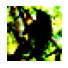

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  2165 true label =  1 3 2 BCNN prediction =  0 0 0 HDCapsNet prediction =  1 0 0
true label = (Coarse > Medium fine) animal > bird > bird
BCNN prediction = (Coarse > Medium fine) transport > sky > airplane
HDCapsNet prediction = (Coarse > Medium fine) animal > sky > airplane


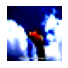

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  2997 true label =  1 3 2 BCNN prediction =  1 5 5 HDCapsNet prediction =  1 5 2
true label = (Coarse > Medium fine) animal > bird > bird
BCNN prediction = (Coarse > Medium fine) animal > pet > dog
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > bird


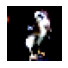

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  3262 true label =  1 3 2 BCNN prediction =  1 5 3 HDCapsNet prediction =  1 5 6
true label = (Coarse > Medium fine) animal > bird > bird
BCNN prediction = (Coarse > Medium fine) animal > pet > cat
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > frog


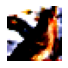

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  4299 true label =  1 3 2 BCNN prediction =  0 1 8 HDCapsNet prediction =  1 0 0
true label = (Coarse > Medium fine) animal > bird > bird
BCNN prediction = (Coarse > Medium fine) transport > water > ship
HDCapsNet prediction = (Coarse > Medium fine) animal > sky > airplane


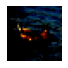

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  6969 true label =  1 3 2 BCNN prediction =  1 4 6 HDCapsNet prediction =  1 4 2
true label = (Coarse > Medium fine) animal > bird > bird
BCNN prediction = (Coarse > Medium fine) animal > reptile > frog
HDCapsNet prediction = (Coarse > Medium fine) animal > reptile > bird


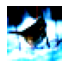

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  9088 true label =  1 3 2 BCNN prediction =  1 4 6 HDCapsNet prediction =  1 5 2
true label = (Coarse > Medium fine) animal > bird > bird
BCNN prediction = (Coarse > Medium fine) animal > reptile > frog
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > bird


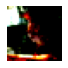

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  9137 true label =  1 3 2 BCNN prediction =  1 0 6 HDCapsNet prediction =  1 6 2
true label = (Coarse > Medium fine) animal > bird > bird
BCNN prediction = (Coarse > Medium fine) animal > sky > frog
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > bird


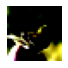

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  9230 true label =  1 3 2 BCNN prediction =  1 3 2 HDCapsNet prediction =  1 0 0
true label = (Coarse > Medium fine) animal > bird > bird
BCNN prediction = (Coarse > Medium fine) animal > bird > bird
HDCapsNet prediction = (Coarse > Medium fine) animal > sky > airplane


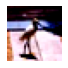

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  9625 true label =  1 3 2 BCNN prediction =  1 3 2 HDCapsNet prediction =  1 0 0
true label = (Coarse > Medium fine) animal > bird > bird
BCNN prediction = (Coarse > Medium fine) animal > bird > bird
HDCapsNet prediction = (Coarse > Medium fine) animal > sky > airplane


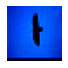

example  9959 true label =  1 3 2 BCNN prediction =  1 3 3 HDCapsNet prediction =  1 5 2
true label = (Coarse > Medium fine) animal > bird > bird
BCNN prediction = (Coarse > Medium fine) animal > bird > cat
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > bird


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


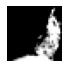

In [30]:
## Check the not consistent examples of bcnn that are consistent in hd
check = []
for i in bcnn_not_consistent.keys():
    if i in hd_consistent.keys():
        
        # if true_label[2][i] == 2 or true_label[2][i] == 9: # only for true label fine = 2 or 9
        if true_label[2][i] == 2: # only for true label fine = 2
            check.append(1)
            
            print('example ', i, 'true label = ', true_label[0][i], true_label[1][i], true_label[2][i],
                'BCNN prediction = ', np.argmax(BCNN_predictions[0][i]), np.argmax(BCNN_predictions[1][i]), np.argmax(BCNN_predictions[2][i]),
                'HDCapsNet prediction = ', np.argmax(HDCapsNet_predictions[0][i]), np.argmax(HDCapsNet_predictions[1][i]), np.argmax(HDCapsNet_predictions[2][i])
                )
            # print true label names
            print('true label = (Coarse > Medium fine)',label_names_coarse[true_label[0][i]], '>', label_names_medium[true_label[1][i]],'>' ,label_names_fine[true_label[2][i]])
            # print bcnn prediction names
            print('BCNN prediction = (Coarse > Medium fine)', label_names_coarse[np.argmax(BCNN_predictions[0][i])], '>',label_names_medium[np.argmax(BCNN_predictions[1][i])], '>',label_names_fine[np.argmax(BCNN_predictions[2][i])])
            # print hd prediction names
            print('HDCapsNet prediction = (Coarse > Medium fine)', label_names_coarse[np.argmax(HDCapsNet_predictions[0][i])], '>',label_names_medium[np.argmax(HDCapsNet_predictions[1][i])], '>',label_names_fine[np.argmax(HDCapsNet_predictions[2][i])])
            plt.figure(figsize = (1,1))
            plt.imshow(dataset['x_test'][i])
            plt.axis('off')
            plt.show()
        
            

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  213 true label =  0 2 9 BCNN prediction =  0 1 9 HDCapsNet prediction =  0 2 9
true label = (Coarse > Medium fine) transport > road > truck
BCNN prediction = (Coarse > Medium fine) transport > water > truck
HDCapsNet prediction = (Coarse > Medium fine) transport > road > truck


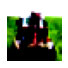

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  394 true label =  0 2 9 BCNN prediction =  1 2 9 HDCapsNet prediction =  0 2 9
true label = (Coarse > Medium fine) transport > road > truck
BCNN prediction = (Coarse > Medium fine) animal > road > truck
HDCapsNet prediction = (Coarse > Medium fine) transport > road > truck


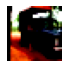

example  485 true label =  0 2 9 BCNN prediction =  0 0 9 HDCapsNet prediction =  0 2 9
true label = (Coarse > Medium fine) transport > road > truck
BCNN prediction = (Coarse > Medium fine) transport > sky > truck
HDCapsNet prediction = (Coarse > Medium fine) transport > road > truck


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


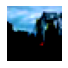

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  719 true label =  0 2 9 BCNN prediction =  0 1 9 HDCapsNet prediction =  0 2 9
true label = (Coarse > Medium fine) transport > road > truck
BCNN prediction = (Coarse > Medium fine) transport > water > truck
HDCapsNet prediction = (Coarse > Medium fine) transport > road > truck


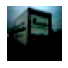

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  744 true label =  0 2 9 BCNN prediction =  1 2 9 HDCapsNet prediction =  0 2 9
true label = (Coarse > Medium fine) transport > road > truck
BCNN prediction = (Coarse > Medium fine) animal > road > truck
HDCapsNet prediction = (Coarse > Medium fine) transport > road > truck


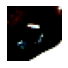

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  923 true label =  0 2 9 BCNN prediction =  0 5 9 HDCapsNet prediction =  0 2 9
true label = (Coarse > Medium fine) transport > road > truck
BCNN prediction = (Coarse > Medium fine) transport > pet > truck
HDCapsNet prediction = (Coarse > Medium fine) transport > road > truck


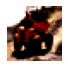

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  1064 true label =  0 2 9 BCNN prediction =  1 2 9 HDCapsNet prediction =  0 2 9
true label = (Coarse > Medium fine) transport > road > truck
BCNN prediction = (Coarse > Medium fine) animal > road > truck
HDCapsNet prediction = (Coarse > Medium fine) transport > road > truck


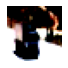

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  1220 true label =  0 2 9 BCNN prediction =  1 1 9 HDCapsNet prediction =  0 2 9
true label = (Coarse > Medium fine) transport > road > truck
BCNN prediction = (Coarse > Medium fine) animal > water > truck
HDCapsNet prediction = (Coarse > Medium fine) transport > road > truck


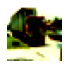

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  1492 true label =  0 2 9 BCNN prediction =  0 2 8 HDCapsNet prediction =  0 2 1
true label = (Coarse > Medium fine) transport > road > truck
BCNN prediction = (Coarse > Medium fine) transport > road > ship
HDCapsNet prediction = (Coarse > Medium fine) transport > road > automobile


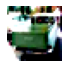

example  1906 true label =  0 2 9 BCNN prediction =  0 6 9 HDCapsNet prediction =  0 2 9
true label = (Coarse > Medium fine) transport > road > truck
BCNN prediction = (Coarse > Medium fine) transport > medium > truck
HDCapsNet prediction = (Coarse > Medium fine) transport > road > truck


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


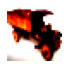

example  1916 true label =  0 2 9 BCNN prediction =  1 2 9 HDCapsNet prediction =  0 2 9
true label = (Coarse > Medium fine) transport > road > truck
BCNN prediction = (Coarse > Medium fine) animal > road > truck
HDCapsNet prediction = (Coarse > Medium fine) transport > road > truck


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


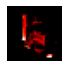

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  2027 true label =  0 2 9 BCNN prediction =  1 2 9 HDCapsNet prediction =  0 2 9
true label = (Coarse > Medium fine) transport > road > truck
BCNN prediction = (Coarse > Medium fine) animal > road > truck
HDCapsNet prediction = (Coarse > Medium fine) transport > road > truck


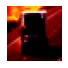

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  2155 true label =  0 2 9 BCNN prediction =  0 2 8 HDCapsNet prediction =  0 2 9
true label = (Coarse > Medium fine) transport > road > truck
BCNN prediction = (Coarse > Medium fine) transport > road > ship
HDCapsNet prediction = (Coarse > Medium fine) transport > road > truck


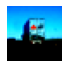

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  2305 true label =  0 2 9 BCNN prediction =  0 3 9 HDCapsNet prediction =  0 2 9
true label = (Coarse > Medium fine) transport > road > truck
BCNN prediction = (Coarse > Medium fine) transport > bird > truck
HDCapsNet prediction = (Coarse > Medium fine) transport > road > truck


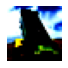

example  2432 true label =  0 2 9 BCNN prediction =  0 0 9 HDCapsNet prediction =  0 2 9
true label = (Coarse > Medium fine) transport > road > truck
BCNN prediction = (Coarse > Medium fine) transport > sky > truck
HDCapsNet prediction = (Coarse > Medium fine) transport > road > truck


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


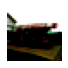

example  2495 true label =  0 2 9 BCNN prediction =  1 1 8 HDCapsNet prediction =  0 1 8
true label = (Coarse > Medium fine) transport > road > truck
BCNN prediction = (Coarse > Medium fine) animal > water > ship
HDCapsNet prediction = (Coarse > Medium fine) transport > water > ship


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


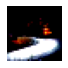

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  2497 true label =  0 2 9 BCNN prediction =  0 0 9 HDCapsNet prediction =  0 2 9
true label = (Coarse > Medium fine) transport > road > truck
BCNN prediction = (Coarse > Medium fine) transport > sky > truck
HDCapsNet prediction = (Coarse > Medium fine) transport > road > truck


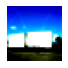

example  2568 true label =  0 2 9 BCNN prediction =  1 6 2 HDCapsNet prediction =  0 2 9
true label = (Coarse > Medium fine) transport > road > truck
BCNN prediction = (Coarse > Medium fine) animal > medium > bird
HDCapsNet prediction = (Coarse > Medium fine) transport > road > truck


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


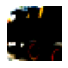

example  2596 true label =  0 2 9 BCNN prediction =  0 2 0 HDCapsNet prediction =  0 2 9
true label = (Coarse > Medium fine) transport > road > truck
BCNN prediction = (Coarse > Medium fine) transport >

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 road > airplane
HDCapsNet prediction = (Coarse > Medium fine) transport > road > truck


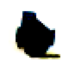

example  2703 true label =  0 2 9 BCNN prediction =  0 0 1 HDCapsNet prediction =  0 2 9
true label = (Coarse > Medium fine) transport > road > truck
BCNN prediction = (Coarse > Medium fine) transport > sky > automobile
HDCapsNet prediction = (Coarse > Medium fine) transport > road > truck


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


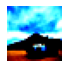

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  2810 true label =  0 2 9 BCNN prediction =  0 6 7 HDCapsNet prediction =  0 2 9
true label = (Coarse > Medium fine) transport > road > truck
BCNN prediction = (Coarse > Medium fine) transport > medium > horse
HDCapsNet prediction = (Coarse > Medium fine) transport > road > truck


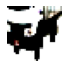

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  2931 true label =  0 2 9 BCNN prediction =  1 2 9 HDCapsNet prediction =  0 2 9
true label = (Coarse > Medium fine) transport > road > truck
BCNN prediction = (Coarse > Medium fine) animal > road > truck
HDCapsNet prediction = (Coarse > Medium fine) transport > road > truck


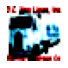

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  3154 true label =  0 2 9 BCNN prediction =  0 2 0 HDCapsNet prediction =  0 0 0
true label = (Coarse > Medium fine) transport > road > truck
BCNN prediction = (Coarse > Medium fine) transport > road > airplane
HDCapsNet prediction = (Coarse > Medium fine) transport > sky > airplane


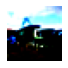

example  3218 true label =  0 2 9 BCNN prediction =  1 0 0 HDCapsNet prediction =  0 2 9
true label = (Coarse > Medium fine) transport > road > truck
BCNN prediction = (Coarse > Medium fine) animal > sky > airplane
HDCapsNet prediction = (Coarse > Medium fine) transport > road > truck


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


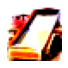

example  3253 true label =  0 2 9 BCNN prediction =  0 2 8 HDCapsNet prediction =  0 2 9
true label = (Coarse > Medium fine) transport > road > truck
BCNN prediction = (Coarse > Medium fine) transport > road > ship
HDCapsNet prediction = (Coarse > Medium fine) transport > road > truck


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


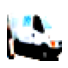

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  3312 true label =  0 2 9 BCNN prediction =  1 2 9 HDCapsNet prediction =  0 2 9
true label = (Coarse > Medium fine) transport > road > truck
BCNN prediction = (Coarse > Medium fine) animal > road > truck
HDCapsNet prediction = (Coarse > Medium fine) transport > road > truck


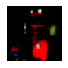

example  3459 true label =  0 2 9 BCNN prediction =  0 2 2 HDCapsNet prediction =  0 2 9
true label = (Coarse > Medium fine) transport > road > truck
BCNN prediction = (Coarse > Medium fine) transport > road > bird
HDCapsNet prediction = (Coarse > Medium fine) transport > road > truck


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


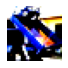

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  3557 true label =  0 2 9 BCNN prediction =  0 4 8 HDCapsNet prediction =  0 2 9
true label = (Coarse > Medium fine) transport > road > truck
BCNN prediction = (Coarse > Medium fine) transport > reptile > ship
HDCapsNet prediction = (Coarse > Medium fine) transport > road > truck


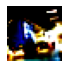

example  3564 true label =  0 2 9 BCNN prediction =  0 0 9 HDCapsNet prediction =  0 2 9
true label = (Coarse > Medium fine) transport > road > truck
BCNN prediction = (Coarse > Medium fine) transport > sky > truck
HDCapsNet prediction = (Coarse > Medium fine) transport > road > truck


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


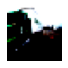

example  3676 true label =  0 2 9 BCNN prediction =  0 0 9 HDCapsNet prediction =  0 2 9
true label = (Coarse > Medium fine) transport > road > truck
BCNN prediction = (Coarse > Medium fine) transport > sky > truck
HDCapsNet prediction = (Coarse > Medium fine) transport > road > truck


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


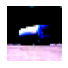

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  3789 true label =  0 2 9 BCNN prediction =  1 2 1 HDCapsNet prediction =  1 4 6
true label = (Coarse > Medium fine) transport > road > truck
BCNN prediction = (Coarse > Medium fine) animal > road > automobile
HDCapsNet prediction = (Coarse > Medium fine) animal > reptile > frog


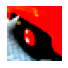

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  3957 true label =  0 2 9 BCNN prediction =  0 6 0 HDCapsNet prediction =  0 0 0
true label = (Coarse > Medium fine) transport > road > truck
BCNN prediction = (Coarse > Medium fine) transport > medium > airplane
HDCapsNet prediction = (Coarse > Medium fine) transport > sky > airplane


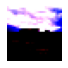

example  3970 true label =  0 2 9 BCNN prediction =  1 2 9 HDCapsNet prediction =  0 2 9
true label = (Coarse > Medium fine) transport > road > truck
BCNN prediction = (Coarse > Medium fine) animal > road > truck
HDCapsNet prediction = (Coarse > Medium fine) transport > road > truck


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


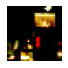

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  3980 true label =  0 2 9 BCNN prediction =  1 0 0 HDCapsNet prediction =  0 2 9
true label = (Coarse > Medium fine) transport > road > truck
BCNN prediction = (Coarse > Medium fine) animal > sky > airplane
HDCapsNet prediction = (Coarse > Medium fine) transport > road > truck


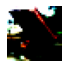

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  4255 true label =  0 2 9 BCNN prediction =  1 0 9 HDCapsNet prediction =  0 2 9
true label = (Coarse > Medium fine) transport > road > truck
BCNN prediction = (Coarse > Medium fine) animal > sky > truck
HDCapsNet prediction = (Coarse > Medium fine) transport > road > truck


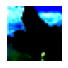

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  4536 true label =  0 2 9 BCNN prediction =  0 2 0 HDCapsNet prediction =  0 2 9
true label = (Coarse > Medium fine) transport > road > truck
BCNN prediction = (Coarse > Medium fine) transport > road > airplane
HDCapsNet prediction = (Coarse > Medium fine) transport > road > truck


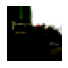

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  4550 true label =  0 2 9 BCNN prediction =  0 2 0 HDCapsNet prediction =  0 2 9
true label = (Coarse > Medium fine) transport > road > truck
BCNN prediction = (Coarse > Medium fine) transport > road > airplane
HDCapsNet prediction = (Coarse > Medium fine) transport > road > truck


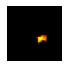

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  4590 true label =  0 2 9 BCNN prediction =  0 3 2 HDCapsNet prediction =  0 2 1
true label = (Coarse > Medium fine) transport > road > truck
BCNN prediction = (Coarse > Medium fine) transport > bird > bird
HDCapsNet prediction = (Coarse > Medium fine) transport > road > automobile


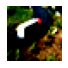

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  4758 true label =  0 2 9 BCNN prediction =  1 2 9 HDCapsNet prediction =  0 2 9
true label = (Coarse > Medium fine) transport > road > truck
BCNN prediction = (Coarse > Medium fine) animal > road > truck
HDCapsNet prediction = (Coarse > Medium fine) transport > road > truck


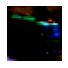

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  4791 true label =  0 2 9 BCNN prediction =  1 6 9 HDCapsNet prediction =  0 2 9
true label = (Coarse > Medium fine) transport > road > truck
BCNN prediction = (Coarse > Medium fine) animal > medium > truck
HDCapsNet prediction = (Coarse > Medium fine) transport > road > truck


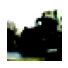

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  5151 true label =  0 2 9 BCNN prediction =  0 5 0 HDCapsNet prediction =  1 5 3
true label = (Coarse > Medium fine) transport > road > truck
BCNN prediction = (Coarse > Medium fine) transport > pet > airplane
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > cat


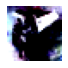

example  5166 true label =  0 2 9 BCNN prediction =  0 6 8 HDCapsNet prediction =  0 1 8
true label = (Coarse > Medium fine) transport > road > truck
BCNN prediction = (Coarse > Medium fine) transport > medium > ship
HDCapsNet prediction = (Coarse > Medium fine) transport > water > ship


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


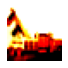

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  5311 true label =  0 2 9 BCNN prediction =  1 2 1 HDCapsNet prediction =  0 2 1
true label = (Coarse > Medium fine) transport > road > truck
BCNN prediction = (Coarse > Medium fine) animal > road > automobile
HDCapsNet prediction = (Coarse > Medium fine) transport > road > automobile


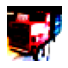

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  5573 true label =  0 2 9 BCNN prediction =  1 6 9 HDCapsNet prediction =  0 2 9
true label = (Coarse > Medium fine) transport > road > truck
BCNN prediction = (Coarse > Medium fine) animal > medium > truck
HDCapsNet prediction = (Coarse > Medium fine) transport > road > truck


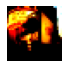

example  5868 true label =  0 2 9 BCNN prediction =  0 0 9 HDCapsNet prediction =  0 2 9
true label = (Coarse > Medium fine) transport > road > truck
BCNN prediction = (Coarse > Medium fine) transport > sky > truck
HDCapsNet prediction = (Coarse > Medium fine) transport > road > truck


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


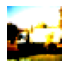

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  5893 true label =  0 2 9 BCNN prediction =  0 2 0 HDCapsNet prediction =  0 0 0
true label = (Coarse > Medium fine) transport > road > truck
BCNN prediction = (Coarse > Medium fine) transport > road > airplane
HDCapsNet prediction = (Coarse > Medium fine) transport > sky > airplane


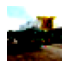

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  6317 true label =  0 2 9 BCNN prediction =  0 0 9 HDCapsNet prediction =  0 2 9
true label = (Coarse > Medium fine) transport > road > truck
BCNN prediction = (Coarse > Medium fine) transport > sky > truck
HDCapsNet prediction = (Coarse > Medium fine) transport > road > truck


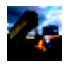

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  6473 true label =  0 2 9 BCNN prediction =  1 0 9 HDCapsNet prediction =  0 2 9
true label = (Coarse > Medium fine) transport > road > truck
BCNN prediction = (Coarse > Medium fine) animal > sky > truck
HDCapsNet prediction = (Coarse > Medium fine) transport > road > truck


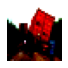

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  6542 true label =  0 2 9 BCNN prediction =  0 0 9 HDCapsNet prediction =  0 2 9
true label = (Coarse > Medium fine) transport > road > truck
BCNN prediction = (Coarse > Medium fine) transport > sky > truck
HDCapsNet prediction = (Coarse > Medium fine) transport > road > truck


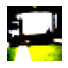

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  6642 true label =  0 2 9 BCNN prediction =  0 5 9 HDCapsNet prediction =  0 2 9
true label = (Coarse > Medium fine) transport > road > truck
BCNN prediction = (Coarse > Medium fine) transport > pet > truck
HDCapsNet prediction = (Coarse > Medium fine) transport > road > truck


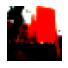

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  6681 true label =  0 2 9 BCNN prediction =  1 2 9 HDCapsNet prediction =  0 2 9
true label = (Coarse > Medium fine) transport > road > truck
BCNN prediction = (Coarse > Medium fine) animal > road > truck
HDCapsNet prediction = (Coarse > Medium fine) transport > road > truck


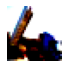

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  6804 true label =  0 2 9 BCNN prediction =  1 2 9 HDCapsNet prediction =  0 2 9
true label = (Coarse > Medium fine) transport > road > truck
BCNN prediction = (Coarse > Medium fine) animal > road > truck
HDCapsNet prediction = (Coarse > Medium fine) transport > road > truck


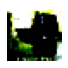

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  6848 true label =  0 2 9 BCNN prediction =  0 0 9 HDCapsNet prediction =  0 2 9
true label = (Coarse > Medium fine) transport > road > truck
BCNN prediction = (Coarse > Medium fine) transport > sky > truck
HDCapsNet prediction = (Coarse > Medium fine) transport > road > truck


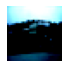

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  6871 true label =  0 2 9 BCNN prediction =  1 2 9 HDCapsNet prediction =  0 2 9
true label = (Coarse > Medium fine) transport > road > truck
BCNN prediction = (Coarse > Medium fine) animal > road > truck
HDCapsNet prediction = (Coarse > Medium fine) transport > road > truck


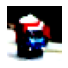

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  7100 true label =  0 2 9 BCNN prediction =  1 5 9 HDCapsNet prediction =  0 2 9
true label = (Coarse > Medium fine) transport > road > truck
BCNN prediction = (Coarse > Medium fine) animal > pet > truck
HDCapsNet prediction = (Coarse > Medium fine) transport > road > truck


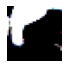

example  7491 true label =  0 2 9 BCNN prediction =  0 6 9 HDCapsNet prediction =  0 2 9
true label = (Coarse > Medium fine) transport > road > truck
BCNN prediction = (Coarse > Medium fine) transport > medium > truck
HDCapsNet prediction = (Coarse > Medium fine) transport > road > truck


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


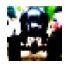

example  7923 true label =  0 2 9 BCNN prediction =  1 2 9 HDCapsNet prediction =  0 2 9
true label = (Coarse > Medium fine) transport > road > truck
BCNN prediction = (Coarse > Medium fine) animal > road > truck
HDCapsNet prediction = (Coarse > Medium fine) transport > road > truck


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


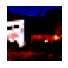

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  7931 true label =  0 2 9 BCNN prediction =  1 2 6 HDCapsNet prediction =  0 2 9
true label = (Coarse > Medium fine) transport > road > truck
BCNN prediction = (Coarse > Medium fine) animal > road > frog
HDCapsNet prediction = (Coarse > Medium fine) transport > road > truck


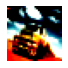

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  7942 true label =  0 2 9 BCNN prediction =  0 0 9 HDCapsNet prediction =  0 2 9
true label = (Coarse > Medium fine) transport > road > truck
BCNN prediction = (Coarse > Medium fine) transport > sky > truck
HDCapsNet prediction = (Coarse > Medium fine) transport > road > truck


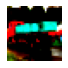

example  8006 true label =  0 2 9 BCNN prediction =  0 6 4 HDCapsNet prediction =  0 2 9
true label = (Coarse > Medium fine) transport > road > truck
BCNN prediction = (Coarse > Medium fine) transport > medium > deer
HDCapsNet prediction = (Coarse > Medium fine) transport > road > truck


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


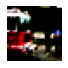

example  8066 true label =  0 2 9 BCNN prediction =  0 5 9 HDCapsNet prediction =  1 5 3
true label = (Coarse > Medium fine) transport > road > truck
BCNN prediction = (Coarse > Medium fine) transport > pet > truck
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > cat


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


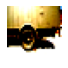

example  8225 true label =  0 2 9 BCNN prediction =  0 0 9 HDCapsNet prediction =  0 2 9
true label = (Coarse > Medium fine) transport > road > truck
BCNN prediction = (Coarse > Medium fine) transport > sky > truck
HDCapsNet prediction = (Coarse > Medium fine) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


transport > road > truck


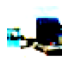

example  8350 true label =  0 2 9 BCNN prediction =  0 0 9 HDCapsNet prediction =  0 2 9
true label = (Coarse > Medium fine) transport > road > truck
BCNN prediction = (Coarse > Medium fine) transport > sky > truck
HDCapsNet prediction = (Coarse > Medium fine) transport > road > truck


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


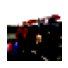

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  8450 true label =  0 2 9 BCNN prediction =  0 5 3 HDCapsNet prediction =  0 2 1
true label = (Coarse > Medium fine) transport > road > truck
BCNN prediction = (Coarse > Medium fine) transport > pet > cat
HDCapsNet prediction = (Coarse > Medium fine) transport > road > automobile


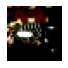

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  8488 true label =  0 2 9 BCNN prediction =  1 6 9 HDCapsNet prediction =  0 2 9
true label = (Coarse > Medium fine) transport > road > truck
BCNN prediction = (Coarse > Medium fine) animal > medium > truck
HDCapsNet prediction = (Coarse > Medium fine) transport > road > truck


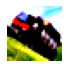

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  8518 true label =  0 2 9 BCNN prediction =  0 6 8 HDCapsNet prediction =  0 2 9
true label = (Coarse > Medium fine) transport > road > truck
BCNN prediction = (Coarse > Medium fine) transport > medium > ship
HDCapsNet prediction = (Coarse > Medium fine) transport > road > truck


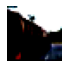

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  8727 true label =  0 2 9 BCNN prediction =  0 1 0 HDCapsNet prediction =  0 0 0
true label = (Coarse > Medium fine) transport > road > truck
BCNN prediction = (Coarse > Medium fine) transport > water > airplane
HDCapsNet prediction = (Coarse > Medium fine) transport > sky > airplane


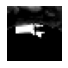

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  8972 true label =  0 2 9 BCNN prediction =  0 2 3 HDCapsNet prediction =  0 0 0
true label = (Coarse > Medium fine) transport > road > truck
BCNN prediction = (Coarse > Medium fine) transport > road > cat
HDCapsNet prediction = (Coarse > Medium fine) transport > sky > airplane


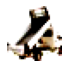

example  8995 true label =  0 2 9 BCNN prediction =  0 6 9 HDCapsNet prediction =  0 2 9
true label = (Coarse > Medium fine) transport > road > truck
BCNN prediction = (Coarse > Medium fine) transport > medium > truck
HDCapsNet prediction = (Coarse > Medium fine) transport > road > truck


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


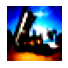

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  9147 true label =  0 2 9 BCNN prediction =  0 6 4 HDCapsNet prediction =  0 2 9
true label = (Coarse > Medium fine) transport > road > truck
BCNN prediction = (Coarse > Medium fine) transport > medium > deer
HDCapsNet prediction = (Coarse > Medium fine) transport > road > truck


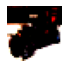

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  9174 true label =  0 2 9 BCNN prediction =  1 2 9 HDCapsNet prediction =  0 2 9
true label = (Coarse > Medium fine) transport > road > truck
BCNN prediction = (Coarse > Medium fine) animal > road > truck
HDCapsNet prediction = (Coarse > Medium fine) transport > road > truck


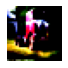

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  9214 true label =  0 2 9 BCNN prediction =  1 2 9 HDCapsNet prediction =  0 2 9
true label = (Coarse > Medium fine) transport > road > truck
BCNN prediction = (Coarse > Medium fine) animal > road > truck
HDCapsNet prediction = (Coarse > Medium fine) transport > road > truck


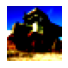

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  9219 true label =  0 2 9 BCNN prediction =  1 6 9 HDCapsNet prediction =  0 2 9
true label = (Coarse > Medium fine) transport > road > truck
BCNN prediction = (Coarse > Medium fine) animal > medium > truck
HDCapsNet prediction = (Coarse > Medium fine) transport > road > truck


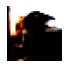

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  9594 true label =  0 2 9 BCNN prediction =  1 2 9 HDCapsNet prediction =  0 2 9
true label = (Coarse > Medium fine) transport > road > truck
BCNN prediction = (Coarse > Medium fine) animal > road > truck
HDCapsNet prediction = (Coarse > Medium fine) transport > road > truck


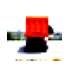

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  9791 true label =  0 2 9 BCNN prediction =  0 6 2 HDCapsNet prediction =  0 2 9
true label = (Coarse > Medium fine) transport > road > truck
BCNN prediction = (Coarse > Medium fine) transport > medium > bird
HDCapsNet prediction = (Coarse > Medium fine) transport > road > truck


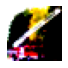

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  9845 true label =  0 2 9 BCNN prediction =  1 2 9 HDCapsNet prediction =  0 2 9
true label = (Coarse > Medium fine) transport > road > truck
BCNN prediction = (Coarse > Medium fine) animal > road > truck
HDCapsNet prediction = (Coarse > Medium fine) transport > road > truck


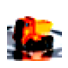

In [59]:
## Check the not consistent examples of bcnn that are consistent in hd
for i in bcnn_not_consistent.keys():
    if i in hd_consistent.keys():
        
        # if true_label[2][i] == 2 or true_label[2][i] == 9: # only for true label fine = 2 or 9
        if true_label[2][i] == 9: # only for true label fine = 2
            print('example ', i, 'true label = ', true_label[0][i], true_label[1][i], true_label[2][i],
                'BCNN prediction = ', np.argmax(BCNN_predictions[0][i]), np.argmax(BCNN_predictions[1][i]), np.argmax(BCNN_predictions[2][i]),
                'HDCapsNet prediction = ', np.argmax(HDCapsNet_predictions[0][i]), np.argmax(HDCapsNet_predictions[1][i]), np.argmax(HDCapsNet_predictions[2][i])
                )
            # print true label names
            print('true label = (Coarse > Medium fine)',label_names_coarse[true_label[0][i]], '>', label_names_medium[true_label[1][i]],'>', label_names_fine[true_label[2][i]])
            # print bcnn prediction names
            print('BCNN prediction = (Coarse > Medium fine)', label_names_coarse[np.argmax(BCNN_predictions[0][i])], '>',label_names_medium[np.argmax(BCNN_predictions[1][i])], '>',label_names_fine[np.argmax(BCNN_predictions[2][i])])
            # print hd prediction names
            print('HDCapsNet prediction = (Coarse > Medium fine)', label_names_coarse[np.argmax(HDCapsNet_predictions[0][i])], '>',label_names_medium[np.argmax(HDCapsNet_predictions[1][i])], '>',label_names_fine[np.argmax(HDCapsNet_predictions[2][i])])
            plt.figure(figsize = (1,1))
            plt.imshow(dataset['x_test'][i])
            plt.axis('off')
            plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  63 true label =  1 5 3 BCNN prediction =  0 5 3 HDCapsNet prediction =  1 5 5
true label = (Coarse > Medium fine) animal > pet > cat
BCNN prediction = (Coarse > Medium fine) transport > pet > cat
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > dog


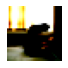

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  103 true label =  1 5 3 BCNN prediction =  1 5 6 HDCapsNet prediction =  1 5 3
true label = (Coarse > Medium fine) animal > pet > cat
BCNN prediction = (Coarse > Medium fine) animal > pet > frog
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > cat


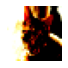

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  168 true label =  1 5 5 BCNN prediction =  1 6 5 HDCapsNet prediction =  1 5 5
true label = (Coarse > Medium fine) animal > pet > dog
BCNN prediction = (Coarse > Medium fine) animal > medium > dog
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > dog


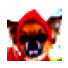

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  367 true label =  1 5 3 BCNN prediction =  1 6 3 HDCapsNet prediction =  1 5 3
true label = (Coarse > Medium fine) animal > pet > cat
BCNN prediction = (Coarse > Medium fine) animal > medium > cat
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > cat


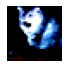

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  399 true label =  1 5 3 BCNN prediction =  0 2 3 HDCapsNet prediction =  1 5 3
true label = (Coarse > Medium fine) animal > pet > cat
BCNN prediction = (Coarse > Medium fine) transport > road > cat
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > cat


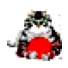

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  426 true label =  1 5 3 BCNN prediction =  1 6 6 HDCapsNet prediction =  1 4 6
true label = (Coarse > Medium fine) animal > pet > cat
BCNN prediction = (Coarse > Medium fine) animal > medium > frog
HDCapsNet prediction = (Coarse > Medium fine) animal > reptile > frog


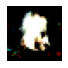

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  457 true label =  1 5 5 BCNN prediction =  1 6 5 HDCapsNet prediction =  1 5 5
true label = (Coarse > Medium fine) animal > pet > dog
BCNN prediction = (Coarse > Medium fine) animal > medium > dog
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > dog


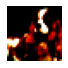

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  464 true label =  1 5 3 BCNN prediction =  1 6 3 HDCapsNet prediction =  1 5 3
true label = (Coarse > Medium fine) animal > pet > cat
BCNN prediction = (Coarse > Medium fine) animal > medium > cat
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > cat


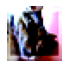

example  715 true label =  1 5 3 BCNN prediction =  1 5 2 HDCapsNet prediction =  1 5 3
true label = (Coarse > Medium fine) animal > pet > cat
BCNN prediction = (Coarse > Medium fine) animal > pet > bird
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > cat


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


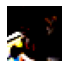

example  810 true label =  1 5 5 BCNN prediction =  1 5 2 HDCapsNet prediction =  1 3 2
true label = (Coarse > Medium fine) animal > pet > dog
BCNN prediction = (Coarse > Medium fine) animal > pet > bird
HDCapsNet prediction = (Coarse > Medium fine) animal > bird > bird


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


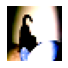

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  819 true label =  1 5 3 BCNN prediction =  1 0 0 HDCapsNet prediction =  1 5 3
true label = (Coarse > Medium fine) animal > pet > cat
BCNN prediction = (Coarse > Medium fine) animal > sky > airplane
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > cat


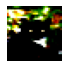

example  831 true label =  1 5 3 BCNN prediction =  0 1 9 HDCapsNet prediction =  1 5 3
true label = (Coarse > Medium fine) animal > pet > cat
BCNN prediction = (Coarse > Medium fine) transport > water > truck
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > cat


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


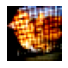

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  845 true label =  1 5 3 BCNN prediction =  1 0 0 HDCapsNet prediction =  1 3 2
true label = (Coarse > Medium fine) animal > pet > cat
BCNN prediction = (Coarse > Medium fine) animal > sky > airplane
HDCapsNet prediction = (Coarse > Medium fine) animal > bird > bird


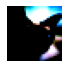

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  862 true label =  1 5 3 BCNN prediction =  1 3 3 HDCapsNet prediction =  1 5 3
true label = (Coarse > Medium fine) animal > pet > cat
BCNN prediction = (Coarse > Medium fine) animal > bird > cat
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > cat


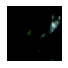

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  878 true label =  1 5 3 BCNN prediction =  1 6 3 HDCapsNet prediction =  1 5 3
true label = (Coarse > Medium fine) animal > pet > cat
BCNN prediction = (Coarse > Medium fine) animal > medium > cat
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > cat


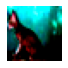

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  882 true label =  1 5 3 BCNN prediction =  1 6 0 HDCapsNet prediction =  1 3 2
true label = (Coarse > Medium fine) animal > pet > cat
BCNN prediction = (Coarse > Medium fine) animal > medium > airplane
HDCapsNet prediction = (Coarse > Medium fine) animal > bird > bird


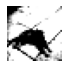

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  898 true label =  1 5 3 BCNN prediction =  1 5 7 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > pet > cat
BCNN prediction = (Coarse > Medium fine) animal > pet > horse
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


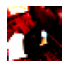

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  924 true label =  1 5 5 BCNN prediction =  1 0 0 HDCapsNet prediction =  1 5 5
true label = (Coarse > Medium fine) animal > pet > dog
BCNN prediction = (Coarse > Medium fine) animal > sky > airplane
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > dog


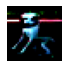

example  1050 true label =  1 5 3 BCNN prediction =  1 0 0 HDCapsNet prediction =  1 5 3
true label = (Coarse > Medium fine) animal > pet > cat
BCNN prediction = (Coarse > Medium fine) animal > sky > airplane
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > cat


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


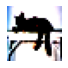

example  1193 true label =  1 5 5 BCNN prediction =  1 5 2 HDCapsNet prediction =  1 5 3
true label = (Coarse > Medium fine) animal > pet > dog
BCNN prediction = (Coarse > Medium fine) animal > pet > bird
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > cat


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


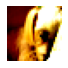

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  1208 true label =  1 5 3 BCNN prediction =  1 3 3 HDCapsNet prediction =  1 5 3
true label = (Coarse > Medium fine) animal > pet > cat
BCNN prediction = (Coarse > Medium fine) animal > bird > cat
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > cat


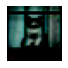

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  1247 true label =  1 5 3 BCNN prediction =  1 5 2 HDCapsNet prediction =  1 5 3
true label = (Coarse > Medium fine) animal > pet > cat
BCNN prediction = (Coarse > Medium fine) animal > pet > bird
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > cat


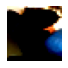

example  1388 true label =  1 5 5 BCNN prediction =  1 5 4 HDCapsNet prediction =  1 5 5
true label = (Coarse > Medium fine) animal > pet > dog
BCNN prediction = (Coarse > Medium fine) animal > pet > deer
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > dog


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


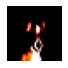

example  1454 true label =  1 5 3 BCNN prediction =  1 5 8 HDCapsNet prediction =  1 5 3
true label = (Coarse > Medium fine) animal > pet > cat
BCNN prediction = (Coarse > Medium fine) animal > pet > ship
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > cat


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


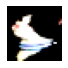

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  1527 true label =  1 5 5 BCNN prediction =  1 6 3 HDCapsNet prediction =  1 5 5
true label = (Coarse > Medium fine) animal > pet > dog
BCNN prediction = (Coarse > Medium fine) animal > medium > cat
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > dog


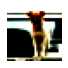

example  1605 true label =  1 5 3 BCNN prediction =  1 5 2 HDCapsNet prediction =  1 5 3
true label = (Coarse > Medium fine) animal > pet > cat
BCNN prediction = (Coarse > Medium fine) animal > pet > bird
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > cat


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


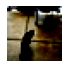

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  1607 true label =  1 5 3 BCNN prediction =  0 2 3 HDCapsNet prediction =  1 5 3
true label = (Coarse > Medium fine) animal > pet > cat
BCNN prediction = (Coarse > Medium fine) transport > road > cat
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > cat


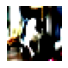

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  1649 true label =  1 5 5 BCNN prediction =  1 3 5 HDCapsNet prediction =  1 5 5
true label = (Coarse > Medium fine) animal > pet > dog
BCNN prediction = (Coarse > Medium fine) animal > bird > dog
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > dog


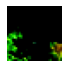

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  1681 true label =  1 5 5 BCNN prediction =  1 5 6 HDCapsNet prediction =  1 5 3
true label = (Coarse > Medium fine) animal > pet > dog
BCNN prediction = (Coarse > Medium fine) animal > pet > frog
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > cat


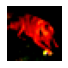

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  1704 true label =  1 5 3 BCNN prediction =  1 0 3 HDCapsNet prediction =  1 5 3
true label = (Coarse > Medium fine) animal > pet > cat
BCNN prediction = (Coarse > Medium fine) animal > sky > cat
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > cat


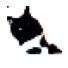

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  1779 true label =  1 5 3 BCNN prediction =  1 5 2 HDCapsNet prediction =  1 5 5
true label = (Coarse > Medium fine) animal > pet > cat
BCNN prediction = (Coarse > Medium fine) animal > pet > bird
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > dog


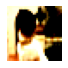

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  1807 true label =  1 5 5 BCNN prediction =  1 6 5 HDCapsNet prediction =  1 5 5
true label = (Coarse > Medium fine) animal > pet > dog
BCNN prediction = (Coarse > Medium fine) animal > medium > dog
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > dog


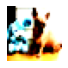

example  1830 true label =  1 5 3 BCNN prediction =  1 3 3 HDCapsNet prediction =  1 5 5
true label = (Coarse > Medium fine) animal > pet > cat
BCNN prediction = (Coarse > Medium fine) animal > bird >

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 cat
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > dog


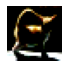

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  1885 true label =  1 5 5 BCNN prediction =  0 5 5 HDCapsNet prediction =  1 5 5
true label = (Coarse > Medium fine) animal > pet > dog
BCNN prediction = (Coarse > Medium fine) transport > pet > dog
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > dog


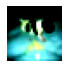

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  1957 true label =  1 5 3 BCNN prediction =  1 6 1 HDCapsNet prediction =  1 5 3
true label = (Coarse > Medium fine) animal > pet > cat
BCNN prediction = (Coarse > Medium fine) animal > medium > automobile
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > cat


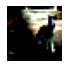

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  2003 true label =  1 5 5 BCNN prediction =  1 5 6 HDCapsNet prediction =  1 5 5
true label = (Coarse > Medium fine) animal > pet > dog
BCNN prediction = (Coarse > Medium fine) animal > pet > frog
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > dog


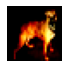

example  2049 true label =  1 5 3 BCNN prediction =  1 6 3 HDCapsNet prediction =  1 5 3
true label = (Coarse > Medium fine) animal > pet > cat
BCNN prediction = (Coarse > Medium fine) animal > medium > cat
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > cat


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


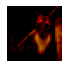

example  2061 true label =  1 5 5 BCNN prediction =  1 6 3 HDCapsNet prediction =  1 5 5
true label = (Coarse > Medium fine) animal > pet > dog
BCNN prediction = (Coarse > Medium fine) animal > medium > cat
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > dog


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


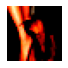

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  2172 true label =  1 5 5 BCNN prediction =  1 0 2 HDCapsNet prediction =  1 3 2
true label = (Coarse > Medium fine) animal > pet > dog
BCNN prediction = (Coarse > Medium fine) animal > sky > bird
HDCapsNet prediction = (Coarse > Medium fine) animal > bird > bird


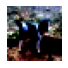

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  2181 true label =  1 5 3 BCNN prediction =  0 2 3 HDCapsNet prediction =  1 5 3
true label = (Coarse > Medium fine) animal > pet > cat
BCNN prediction = (Coarse > Medium fine) transport > road > cat
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > cat


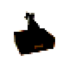

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  2219 true label =  1 5 5 BCNN prediction =  1 4 1 HDCapsNet prediction =  1 5 5
true label = (Coarse > Medium fine) animal > pet > dog
BCNN prediction = (Coarse > Medium fine) animal > reptile > automobile
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > dog


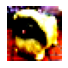

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  2300 true label =  1 5 3 BCNN prediction =  1 6 2 HDCapsNet prediction =  1 5 3
true label = (Coarse > Medium fine) animal > pet > cat
BCNN prediction = (Coarse > Medium fine) animal > medium > bird
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > cat


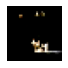

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  2320 true label =  1 5 5 BCNN prediction =  1 5 2 HDCapsNet prediction =  1 5 5
true label = (Coarse > Medium fine) animal > pet > dog
BCNN prediction = (Coarse > Medium fine) animal > pet > bird
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > dog


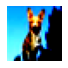

example  2350 true label =  1 5 3 BCNN prediction =  1 2 5 HDCapsNet prediction =  1 5 5
true label = (Coarse > Medium fine) animal > pet > cat
BCNN prediction = (Coarse > Medium fine) animal > road > dog
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > dog


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


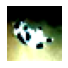

example  2384 true label =  1 5 5 BCNN prediction =  1 5 7 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > pet > dog
BCNN prediction = (Coarse > Medium fine) animal > pet > horse
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


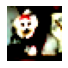

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  2444 true label =  1 5 3 BCNN prediction =  1 5 6 HDCapsNet prediction =  1 3 2
true label = (Coarse > Medium fine) animal > pet > cat
BCNN prediction = (Coarse > Medium fine) animal > pet > frog
HDCapsNet prediction = (Coarse > Medium fine) animal > bird > bird


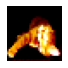

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  2494 true label =  1 5 5 BCNN prediction =  1 6 2 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > pet > dog
BCNN prediction = (Coarse > Medium fine) animal > medium > bird
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


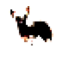

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  2506 true label =  1 5 3 BCNN prediction =  0 5 3 HDCapsNet prediction =  1 5 3
true label = (Coarse > Medium fine) animal > pet > cat
BCNN prediction = (Coarse > Medium fine) transport > pet > cat
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > cat


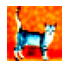

example  2524 true label =  1 5 3 BCNN prediction =  1 6 5 HDCapsNet prediction =  1 5 3
true label = (Coarse > Medium fine) animal > pet > cat
BCNN prediction = (Coarse > Medium fine) animal > medium > dog
HDCapsNet prediction = (Coarse > Medium fine) animal > pet >

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 cat


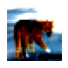

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  2525 true label =  1 5 5 BCNN prediction =  1 0 0 HDCapsNet prediction =  1 3 2
true label = (Coarse > Medium fine) animal > pet > dog
BCNN prediction = (Coarse > Medium fine) animal > sky > airplane
HDCapsNet prediction = (Coarse > Medium fine) animal > bird > bird


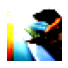

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  2590 true label =  1 5 5 BCNN prediction =  1 5 2 HDCapsNet prediction =  1 5 3
true label = (Coarse > Medium fine) animal > pet > dog
BCNN prediction = (Coarse > Medium fine) animal > pet > bird
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > cat


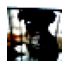

example  2651 true label =  1 5 5 BCNN prediction =  0 5 5 HDCapsNet prediction =  1 5 3
true label = (Coarse > Medium fine) animal > pet > dog
BCNN prediction = (Coarse > Medium fine) transport > pet > dog
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > cat


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


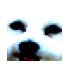

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  2722 true label =  1 5 5 BCNN prediction =  1 5 4 HDCapsNet prediction =  1 5 5
true label = (Coarse > Medium fine) animal > pet > dog
BCNN prediction = (Coarse > Medium fine) animal > pet > deer
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > dog


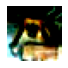

example  2775 true label =  1 5 3 BCNN prediction =  1 5 4 HDCapsNet prediction =  1 5 3
true label = (Coarse > Medium fine) animal > pet > cat
BCNN prediction = (Coarse > Medium fine) animal > pet > deer
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > cat


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


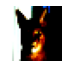

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  2779 true label =  1 5 3 BCNN prediction =  1 5 2 HDCapsNet prediction =  1 5 3
true label = (Coarse > Medium fine) animal > pet > cat
BCNN prediction = (Coarse > Medium fine) animal > pet > bird
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > cat


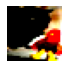

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  2823 true label =  1 5 3 BCNN prediction =  1 0 4 HDCapsNet prediction =  1 5 3
true label = (Coarse > Medium fine) animal > pet > cat
BCNN prediction = (Coarse > Medium fine) animal > sky > deer
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > cat


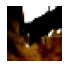

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  2831 true label =  1 5 3 BCNN prediction =  0 2 3 HDCapsNet prediction =  0 2 9
true label = (Coarse > Medium fine) animal > pet > cat
BCNN prediction = (Coarse > Medium fine) transport > road > cat
HDCapsNet prediction = (Coarse > Medium fine) transport > road > truck


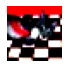

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  2923 true label =  1 5 3 BCNN prediction =  1 6 3 HDCapsNet prediction =  1 5 3
true label = (Coarse > Medium fine) animal > pet > cat
BCNN prediction = (Coarse > Medium fine) animal > medium > cat
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > cat


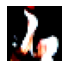

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  2948 true label =  1 5 5 BCNN prediction =  1 6 0 HDCapsNet prediction =  0 0 0
true label = (Coarse > Medium fine) animal > pet > dog
BCNN prediction = (Coarse > Medium fine) animal > medium > airplane
HDCapsNet prediction = (Coarse > Medium fine) transport > sky > airplane


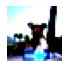

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  3092 true label =  1 5 5 BCNN prediction =  1 5 7 HDCapsNet prediction =  1 5 5
true label = (Coarse > Medium fine) animal > pet > dog
BCNN prediction = (Coarse > Medium fine) animal > pet > horse
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > dog


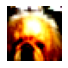

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  3113 true label =  1 5 3 BCNN prediction =  1 4 3 HDCapsNet prediction =  1 5 3
true label = (Coarse > Medium fine) animal > pet > cat
BCNN prediction = (Coarse > Medium fine) animal > reptile > cat
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > cat


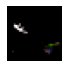

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  3192 true label =  1 5 5 BCNN prediction =  1 5 4 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > pet > dog
BCNN prediction = (Coarse > Medium fine) animal > pet > deer
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


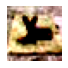

example  3264 true label =  1 5 5 BCNN prediction =  0 0 4 HDCapsNet prediction =  1 5 5
true label = (Coarse > Medium fine) animal > pet > dog
BCNN prediction = (Coarse > Medium fine) transport > sky > deer
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > dog


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


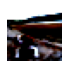

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  3324 true label =  1 5 3 BCNN prediction =  1 4 3 HDCapsNet prediction =  1 5 3
true label = (Coarse > Medium fine) animal > pet > cat
BCNN prediction = (Coarse > Medium fine) animal > reptile > cat
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > cat


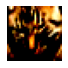

example  3354 true label =  1 5 3 BCNN prediction =  0 5 8 HDCapsNet prediction =  1 3 2
true label = (Coarse > Medium fine) animal > pet > cat
BCNN prediction = (Coarse > Medium fine) transport > pet > ship
HDCapsNet prediction = (Coarse > Medium fine) animal > bird > bird


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


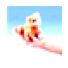

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  3355 true label =  1 5 5 BCNN prediction =  0 2 5 HDCapsNet prediction =  1 4 6
true label = (Coarse > Medium fine) animal > pet > dog
BCNN prediction = (Coarse > Medium fine) transport > road > dog
HDCapsNet prediction = (Coarse > Medium fine) animal > reptile > frog


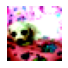

example  3496 true label =  1 5 5 BCNN prediction =  1 6 6 HDCapsNet prediction =  1 5 3
true label = (Coarse > Medium fine) animal > pet > dog
BCNN prediction = (Coarse > Medium fine) animal > medium > frog
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > cat


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


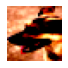

example  3726

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 true label =  1 5 5 BCNN prediction =  1 6 5 HDCapsNet prediction =  1 5 5
true label = (Coarse > Medium fine) animal > pet > dog
BCNN prediction = (Coarse > Medium fine) animal > medium > dog
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > dog


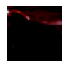

example  3752 true label =  1 5 3 BCNN prediction =  0 5 3 HDCapsNet prediction =  1 5 3
true label = (Coarse > Medium fine) animal > pet > cat
BCNN prediction = (Coarse > Medium fine) transport > pet > cat
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > cat


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


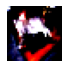

example  3868 true label =  1 5 5 BCNN prediction =  1 6 5 HDCapsNet prediction =  1 5 5
true label = (Coarse > Medium fine) animal > pet > dog
BCNN prediction = (Coarse > Medium fine) animal > medium > dog
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > dog


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


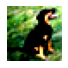

example  4012 true label =  1 5 3 BCNN prediction =  1 5 7 HDCapsNet prediction =  1 5 5
true label = (Coarse > Medium fine) animal > pet > cat
BCNN prediction = (Coarse > Medium fine) animal > pet > horse
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > dog


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


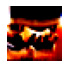

example  4097 true label =  1 5 3 BCNN prediction =  1 5 2 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > pet > cat
BCNN prediction = (Coarse > Medium fine) animal > pet > bird
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


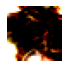

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  4139 true label =  1 5 5 BCNN prediction =  0 6 4 HDCapsNet prediction =  1 5 3
true label = (Coarse > Medium fine) animal > pet > dog
BCNN prediction = (Coarse > Medium fine) transport > medium > deer
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > cat


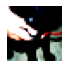

example  4152 true label =  1 5 5 BCNN prediction =  1 2 1 HDCapsNet prediction =  1 5 3
true label = (Coarse > Medium fine) animal > pet > dog
BCNN prediction = (Coarse > Medium fine) animal > road > automobile
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > cat


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


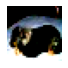

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  4190 true label =  1 5 3 BCNN prediction =  1 5 7 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > pet > cat
BCNN prediction = (Coarse > Medium fine) animal > pet > horse
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


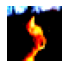

example  4442 true label =  1 5 3 BCNN prediction =  0 0 9 HDCapsNet prediction =  0 0 0
true label = (Coarse > Medium fine) animal > pet > cat
BCNN prediction = (Coarse > Medium fine) transport > sky > truck
HDCapsNet prediction = (Coarse > Medium fine) transport > sky > airplane


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


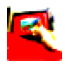

example  4485 true label =  1 5 3 BCNN prediction =  1 5 7 HDCapsNet prediction =  1 5 3
true label = (Coarse > Medium fine) animal > pet > cat
BCNN prediction = (Coarse > Medium fine) animal > pet > horse
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > cat


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


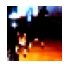

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  4499 true label =  1 5 3 BCNN prediction =  1 3 3 HDCapsNet prediction =  1 5 3
true label = (Coarse > Medium fine) animal > pet > cat
BCNN prediction = (Coarse > Medium fine) animal > bird > cat
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > cat


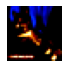

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  4528 true label =  1 5 5 BCNN prediction =  1 6 3 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > pet > dog
BCNN prediction = (Coarse > Medium fine) animal > medium > cat
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


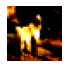

example  4574 true label =  1 5 3 BCNN prediction =  1 5 4 HDCapsNet prediction =  1 5 3
true label = (Coarse > Medium fine) animal > pet > cat
BCNN prediction = (Coarse > Medium fine) animal > pet > deer
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > cat


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


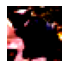

example  4581 true label =  1 5 3 BCNN prediction =  1 5 2 HDCapsNet prediction =  1 5 5
true label = (Coarse > Medium fine) animal > pet > cat
BCNN prediction = (Coarse > Medium fine) animal > pet > bird
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > dog


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


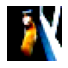

example  4605 true label =  1 5 3 BCNN prediction =  1 4 2 HDCapsNet prediction =  1 5 3
true label = (Coarse > Medium fine) animal > pet > cat
BCNN prediction = (Coarse > Medium fine) animal > reptile > bird
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > cat


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


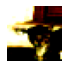

example 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 4705 true label =  1 5 3 BCNN prediction =  1 5 4 HDCapsNet prediction =  1 3 2
true label = (Coarse > Medium fine) animal > pet > cat
BCNN prediction = (Coarse > Medium fine) animal > pet > deer
HDCapsNet prediction = (Coarse > Medium fine) animal > bird > bird


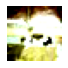

example  4754 true label =  1 5 3 BCNN prediction =  1 1 8 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > pet > cat
BCNN prediction = (Coarse > Medium fine) animal > water > ship
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


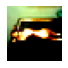

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  4814 true label =  1 5 3 BCNN prediction =  1 0 3 HDCapsNet prediction =  1 4 6
true label = (Coarse > Medium fine) animal > pet > cat
BCNN prediction = (Coarse > Medium fine) animal > sky > cat
HDCapsNet prediction = (Coarse > Medium fine) animal > reptile > frog


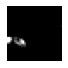

example  4823 true label =  1 5 5 BCNN prediction =  1 5 4 HDCapsNet prediction =  1 5 3
true label = (Coarse > Medium fine) animal > pet > dog
BCNN prediction = (Coarse > Medium fine) animal > pet > deer
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > cat


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


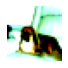

example  4862 true label =  1 5 3 BCNN prediction =  1 3 0 HDCapsNet prediction =  1 5 3
true label = (Coarse > Medium fine) animal > pet > cat
BCNN prediction = (Coarse > Medium fine) animal > bird > airplane
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > cat


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


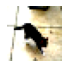

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  4907 true label =  1 5 5 BCNN prediction =  1 5 7 HDCapsNet prediction =  1 5 5
true label = (Coarse > Medium fine) animal > pet > dog
BCNN prediction = (Coarse > Medium fine) animal > pet > horse
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > dog


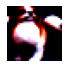

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  4921 true label =  1 5 5 BCNN prediction =  0 5 3 HDCapsNet prediction =  1 4 6
true label = (Coarse > Medium fine) animal > pet > dog
BCNN prediction = (Coarse > Medium fine) transport > pet > cat
HDCapsNet prediction = (Coarse > Medium fine) animal > reptile > frog


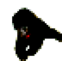

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  4933 true label =  1 5 3 BCNN prediction =  1 6 3 HDCapsNet prediction =  1 5 3
true label = (Coarse > Medium fine) animal > pet > cat
BCNN prediction = (Coarse > Medium fine) animal > medium > cat
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > cat


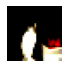

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  4962 true label =  1 5 3 BCNN prediction =  0 5 3 HDCapsNet prediction =  1 5 3
true label = (Coarse > Medium fine) animal > pet > cat
BCNN prediction = (Coarse > Medium fine) transport > pet > cat
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > cat


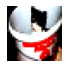

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  4963 true label =  1 5 3 BCNN prediction =  1 4 5 HDCapsNet prediction =  1 5 3
true label = (Coarse > Medium fine) animal > pet > cat
BCNN prediction = (Coarse > Medium fine) animal > reptile > dog
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > cat


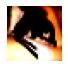

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  4982 true label =  1 5 3 BCNN prediction =  1 5 7 HDCapsNet prediction =  1 5 3
true label = (Coarse > Medium fine) animal > pet > cat
BCNN prediction = (Coarse > Medium fine) animal > pet > horse
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > cat


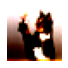

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  5029 true label =  1 5 3 BCNN prediction =  1 5 2 HDCapsNet prediction =  1 5 5
true label = (Coarse > Medium fine) animal > pet > cat
BCNN prediction = (Coarse > Medium fine) animal > pet > bird
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > dog


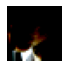

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  5086 true label =  1 5 3 BCNN prediction =  1 3 3 HDCapsNet prediction =  1 5 3
true label = (Coarse > Medium fine) animal > pet > cat
BCNN prediction = (Coarse > Medium fine) animal > bird > cat
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > cat


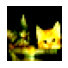

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  5112 true label =  1 5 5 BCNN prediction =  1 2 7 HDCapsNet prediction =  1 5 5
true label = (Coarse > Medium fine) animal > pet > dog
BCNN prediction = (Coarse > Medium fine) animal > road > horse
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > dog


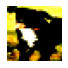

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  5128 true label =  1 5 3 BCNN prediction =  1 6 3 HDCapsNet prediction =  1 5 3
true label = (Coarse > Medium fine) animal > pet > cat
BCNN prediction = (Coarse > Medium fine) animal > medium > cat
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > cat


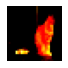

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  5130 true label =  1 5 5 BCNN prediction =  1 5 2 HDCapsNet prediction =  1 5 3
true label = (Coarse > Medium fine) animal > pet > dog
BCNN prediction = (Coarse > Medium fine) animal > pet > bird
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > cat


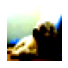

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  5156 true label =  1 5 5 BCNN prediction =  0 5 5 HDCapsNet prediction =  1 5 5
true label = (Coarse > Medium fine) animal > pet > dog
BCNN prediction = (Coarse > Medium fine) transport > pet > dog
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > dog


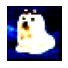

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  5176 true label =  1 5 3 BCNN prediction =  1 5 9 HDCapsNet prediction =  0 2 9
true label = (Coarse > Medium fine) animal > pet > cat
BCNN prediction = (Coarse > Medium fine) animal > pet > truck
HDCapsNet prediction = (Coarse > Medium fine) transport > road > truck


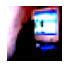

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  5198 true label =  1 5 3 BCNN prediction =  0 5 0 HDCapsNet prediction =  1 5 3
true label = (Coarse > Medium fine) animal > pet > cat
BCNN prediction = (Coarse > Medium fine) transport > pet > airplane
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > cat


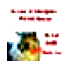

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  5298 true label =  1 5 5 BCNN prediction =  1 5 2 HDCapsNet prediction =  1 5 5
true label = (Coarse > Medium fine) animal > pet > dog
BCNN prediction = (Coarse > Medium fine) animal > pet > bird
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > dog


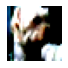

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  5410 true label =  1 5 3 BCNN prediction =  1 5 2 HDCapsNet prediction =  1 5 5
true label = (Coarse > Medium fine) animal > pet > cat
BCNN prediction = (Coarse > Medium fine) animal > pet > bird
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > dog


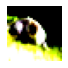

example  5468 true label =  1 5 5 BCNN prediction =  0 3 2 HDCapsNet prediction =  1 5 3
true label = (Coarse > Medium fine) animal > pet > dog
BCNN prediction = (Coarse > Medium fine) transport > bird > bird
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > cat


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


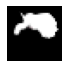

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  5493 true label =  1 5 3 BCNN prediction =  1 4 3 HDCapsNet prediction =  1 5 3
true label = (Coarse > Medium fine) animal > pet > cat
BCNN prediction = (Coarse > Medium fine) animal > reptile > cat
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > cat


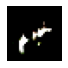

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  5597 true label =  1 5 3 BCNN prediction =  0 5 3 HDCapsNet prediction =  1 5 3
true label = (Coarse > Medium fine) animal > pet > cat
BCNN prediction = (Coarse > Medium fine) transport > pet > cat
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > cat


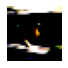

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  5730 true label =  1 5 5 BCNN prediction =  0 6 4 HDCapsNet prediction =  1 3 2
true label = (Coarse > Medium fine) animal > pet > dog
BCNN prediction = (Coarse > Medium fine) transport > medium > deer
HDCapsNet prediction = (Coarse > Medium fine) animal > bird > bird


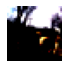

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  5773 true label =  1 5 3 BCNN prediction =  1 3 3 HDCapsNet prediction =  1 5 3
true label = (Coarse > Medium fine) animal > pet > cat
BCNN prediction = (Coarse > Medium fine) animal > bird > cat
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > cat


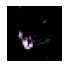

example  5796 true label =  1 5 5 BCNN prediction =  1 5 7 HDCapsNet prediction =  1 5 5
true label = (Coarse > Medium fine) animal > pet > dog
BCNN prediction = (Coarse > Medium fine) animal > pet > horse
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > dog


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


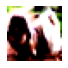

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  5930 true label =  1 5 5 BCNN prediction =  1 6 5 HDCapsNet prediction =  1 5 5
true label = (Coarse > Medium fine) animal > pet > dog
BCNN prediction = (Coarse > Medium fine) animal > medium > dog
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > dog


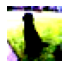

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  5955 true label =  1 5 5 BCNN prediction =  1 4 5 HDCapsNet prediction =  1 5 5
true label = (Coarse > Medium fine) animal > pet > dog
BCNN prediction = (Coarse > Medium fine) animal > reptile > dog
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > dog


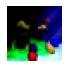

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  5979 true label =  1 5 5 BCNN prediction =  1 2 5 HDCapsNet prediction =  1 5 5
true label = (Coarse > Medium fine) animal > pet > dog
BCNN prediction = (Coarse > Medium fine) animal > road > dog
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > dog


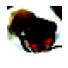

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  5986 true label =  1 5 3 BCNN prediction =  1 5 7 HDCapsNet prediction =  1 5 3
true label = (Coarse > Medium fine) animal > pet > cat
BCNN prediction = (Coarse > Medium fine) animal > pet > horse
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > cat


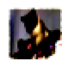

example  6008 true label =  1 5 3 BCNN prediction =  1 3 3 HDCapsNet prediction =  1 3 2
true label = (Coarse > Medium fine) animal > pet > cat
BCNN prediction = (Coarse > Medium fine) animal > bird > cat
HDCapsNet prediction = (Coarse > Medium fine) animal > bird > bird


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


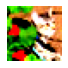

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  6102 true label =  1 5 3 BCNN prediction =  1 2 9 HDCapsNet prediction =  0 2 9
true label = (Coarse > Medium fine) animal > pet > cat
BCNN prediction = (Coarse > Medium fine) animal > road > truck
HDCapsNet prediction = (Coarse > Medium fine) transport > road > truck


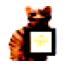

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  6134 true label =  1 5 3 BCNN prediction =  0 3 2 HDCapsNet prediction =  0 2 9
true label = (Coarse > Medium fine) animal > pet > cat
BCNN prediction = (Coarse > Medium fine) transport > bird > bird
HDCapsNet prediction = (Coarse > Medium fine) transport > road > truck


In [60]:
## Check the not consistent examples of bcnn that are consistent in hd
for i in bcnn_not_consistent.keys():
    if i in hd_consistent.keys():
        
        if true_label[2][i] == 3 or true_label[2][i] == 5: # only for true label fine = 2 or 9
        # if true_label[2][i] == 9: # only for true label fine = 2
            print('example ', i, 'true label = ', true_label[0][i], true_label[1][i], true_label[2][i],
                'BCNN prediction = ', np.argmax(BCNN_predictions[0][i]), np.argmax(BCNN_predictions[1][i]), np.argmax(BCNN_predictions[2][i]),
                'HDCapsNet prediction = ', np.argmax(HDCapsNet_predictions[0][i]), np.argmax(HDCapsNet_predictions[1][i]), np.argmax(HDCapsNet_predictions[2][i])
                )
            # print true label names
            print('true label = (Coarse > Medium fine)',label_names_coarse[true_label[0][i]], '>', label_names_medium[true_label[1][i]],'>', label_names_fine[true_label[2][i]])
            # print bcnn prediction names
            print('BCNN prediction = (Coarse > Medium fine)', label_names_coarse[np.argmax(BCNN_predictions[0][i])], '>',label_names_medium[np.argmax(BCNN_predictions[1][i])], '>',label_names_fine[np.argmax(BCNN_predictions[2][i])])
            # print hd prediction names
            print('HDCapsNet prediction = (Coarse > Medium fine)', label_names_coarse[np.argmax(HDCapsNet_predictions[0][i])], '>',label_names_medium[np.argmax(HDCapsNet_predictions[1][i])], '>',label_names_fine[np.argmax(HDCapsNet_predictions[2][i])])
            plt.figure(figsize = (1,1))
            plt.imshow(dataset['x_test'][i])
            plt.axis('off')
            plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  119 true label =  1 6 7 BCNN prediction =  1 5 7 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) animal > pet > horse
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


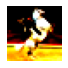

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  211 true label =  1 6 4 BCNN prediction =  0 6 4 HDCapsNet prediction =  0 0 0
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) transport > medium > deer
HDCapsNet prediction = (Coarse > Medium fine) transport > sky > airplane


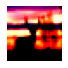

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  263 true label =  1 6 7 BCNN prediction =  1 5 7 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) animal > pet > horse
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


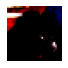

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  370 true label =  1 6 4 BCNN prediction =  1 5 2 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > pet > bird
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


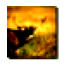

example  410 true label =  1 6 7 BCNN prediction =  1 5 7 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) animal > pet > horse
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


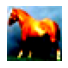

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  455 true label =  1 6 4 BCNN prediction =  1 5 4 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > pet > deer
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


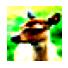

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  606 true label =  1 6 4 BCNN prediction =  1 5 4 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > pet > deer
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


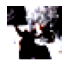

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  682 true label =  1 6 4 BCNN prediction =  0 6 4 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) transport > medium > deer
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


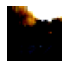

example  735 true label =  1 6 4 BCNN prediction =  1 3 6 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > bird > frog
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


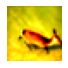

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  773 true label =  1 6 4 BCNN prediction =  1 5 4 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > pet > deer
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


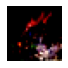

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  808 true label =  1 6 7 BCNN prediction =  1 0 0 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) animal > sky > airplane
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


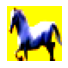

example  809 true label =  1 6 7 BCNN prediction =  1 5 7 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) animal > pet > horse
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


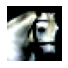

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  943 true label =  1 6 4 BCNN prediction =  1 6 6 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > medium > frog
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


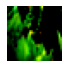

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  974 true label =  1 6 7 BCNN prediction =  1 6 0 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) animal > medium > airplane
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


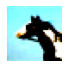

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  993 true label =  1 6 4 BCNN prediction =  1 6 3 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > medium > cat
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


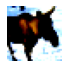

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  1040 true label =  1 6 7 BCNN prediction =  1 3 7 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) animal > bird > horse
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


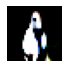

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  1145 true label =  1 6 4 BCNN prediction =  1 5 4 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > pet > deer
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


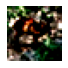

example  1207 true label =  1 6 4 BCNN prediction =  0 6 4 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) transport > medium > deer
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


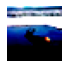

example  1299 true label =  1 6 7 BCNN prediction =  1 0 0 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) animal > sky > airplane
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


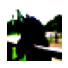

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  1304 true label =  1 6 4 BCNN prediction =  1 1 8 HDCapsNet prediction =  0 1 8
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > water > ship
HDCapsNet prediction = (Coarse > Medium fine) transport > water > ship


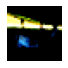

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  1391 true label =  1 6 7 BCNN prediction =  1 5 2 HDCapsNet prediction =  1 5 5
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) animal > pet > bird
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > dog


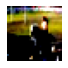

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  1393 true label =  1 6 4 BCNN prediction =  1 6 3 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > medium > cat
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


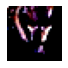

example  1470 true label =  1 6 7 BCNN prediction =  1 5 2 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) animal > pet > bird
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


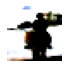

example  1491 true label =  1 6 4 BCNN prediction =  1 6 3 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > medium > cat
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


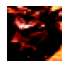

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  1516 true label =  1 6 4 BCNN prediction =  0 6 4 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) transport > medium > deer
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


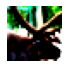

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  1608 true label =  1 6 4 BCNN prediction =  1 5 4 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > pet > deer
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


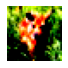

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  1696 true label =  1 6 4 BCNN prediction =  1 6 0 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > medium > airplane
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


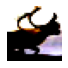

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  1710 true label =  1 6 4 BCNN prediction =  1 5 4 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > pet > deer
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


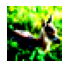

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  1720 true label =  1 6 4 BCNN prediction =  1 5 4 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > pet > deer
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


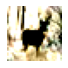

example  1730 true label =  1 6 4 BCNN prediction =  1 6 8 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > medium > ship
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


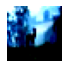

example  1821 true label =  1 6 4 BCNN prediction =  1 5 4 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > pet > deer
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


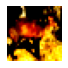

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  1822 true label =  1 6 7 BCNN prediction =  1 3 7 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) animal > bird > horse
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


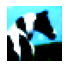

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  1828 true label =  1 6 7 BCNN prediction =  0 6 9 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) transport > medium > truck
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


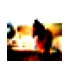

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  1878 true label =  1 6 7 BCNN prediction =  0 6 7 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) transport > medium > horse
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


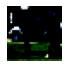

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  1941 true label =  1 6 7 BCNN prediction =  1 6 2 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) animal > medium > bird
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


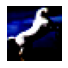

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  1971 true label =  1 6 4 BCNN prediction =  1 5 4 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > pet > deer
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


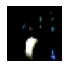

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  2010 true label =  1 6 7 BCNN prediction =  1 5 7 HDCapsNet prediction =  1 3 2
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) animal > pet > horse
HDCapsNet prediction = (Coarse > Medium fine) animal > bird > bird


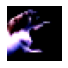

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  2032 true label =  1 6 4 BCNN prediction =  1 3 4 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > bird > deer
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


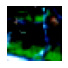

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  2117 true label =  1 6 7 BCNN prediction =  0 6 7 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) transport > medium > horse
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


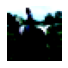

example  2120 true label =  1 6 4 BCNN prediction =  1 6 0 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > medium > airplane
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


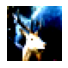

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  2191 true label =  1 6 4 BCNN prediction =  1 5 4 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > pet > deer
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


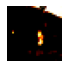

example  2213 true label =  1 6 4 BCNN prediction =  1 6 6 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > medium > frog
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


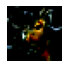

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  2272 true label =  1 6 7 BCNN prediction =  1 5 7 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) animal > pet > horse
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


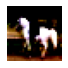

example  2358 true label =  1 6 7 BCNN prediction =  1 5 7 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) animal > pet > horse
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


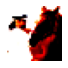

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  2386 true label =  1 6 4 BCNN prediction =  1 5 0 HDCapsNet prediction =  1 5 3
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > pet > airplane
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > cat


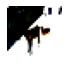

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  2442 true label =  1 6 4 BCNN prediction =  1 5 2 HDCapsNet prediction =  1 5 3
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > pet > bird
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > cat


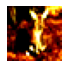

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  2505 true label =  1 6 7 BCNN prediction =  0 6 7 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) transport > medium > horse
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


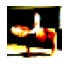

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  2547 true label =  1 6 4 BCNN prediction =  1 4 4 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > reptile > deer
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


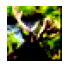

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  2611 true label =  1 6 4 BCNN prediction =  1 6 3 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > medium > cat
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


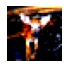

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  2677 true label =  1 6 7 BCNN prediction =  1 6 5 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) animal > medium > dog
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


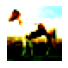

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  2719 true label =  1 6 4 BCNN prediction =  1 5 2 HDCapsNet prediction =  1 5 3
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > pet > bird
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > cat


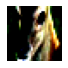

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  2753 true label =  1 6 7 BCNN prediction =  1 5 7 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) animal > pet > horse
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


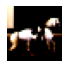

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  2761 true label =  1 6 7 BCNN prediction =  0 6 7 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) transport > medium > horse
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


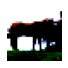

example  2770 true label =  1 6 7 BCNN prediction =  1 5 4 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) animal > pet > deer
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


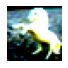

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  2788 true label =  1 6 7 BCNN prediction =  1 3 7 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) animal > bird > horse
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


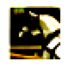

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  2809 true label =  1 6 4 BCNN prediction =  1 5 4 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > pet > deer
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


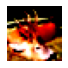

example  2835 true label =  1 6 4 BCNN prediction =  1 6 1 HDCapsNet prediction =  1 5 3
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > medium > automobile
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > cat


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


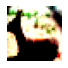

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  2888 true label =  1 6 7 BCNN prediction =  1 6 3 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) animal > medium > cat
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


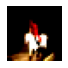

example  2889 true label =  1 6 7 BCNN prediction =  1 5 7 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) animal > pet > horse
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


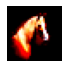

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  2891 true label =  1 6 7 BCNN prediction =  1 5 7 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) animal > pet > horse
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


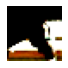

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  2981 true label =  1 6 4 BCNN prediction =  1 5 4 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > pet > deer
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


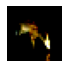

example  3031 true label =  1 6 7 BCNN prediction =  1 5 7 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


BCNN prediction = (Coarse > Medium fine) animal > pet > horse
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


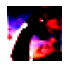

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  3110 true label =  1 6 7 BCNN prediction =  1 5 2 HDCapsNet prediction =  1 5 5
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) animal > pet > bird
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > dog


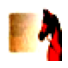

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  3186 true label =  1 6 7 BCNN prediction =  1 4 0 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) animal > reptile > airplane
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


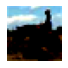

example  3240 true label =  1 6 4 BCNN prediction =  1 4 4 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > reptile > deer
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


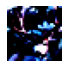

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  3283 true label =  1 6 7 BCNN prediction =  1 5 7 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) animal > pet > horse
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


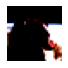

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  3346 true label =  1 6 4 BCNN prediction =  0 6 4 HDCapsNet prediction =  1 3 2
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) transport > medium > deer
HDCapsNet prediction = (Coarse > Medium fine) animal > bird > bird


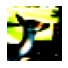

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  3415 true label =  1 6 7 BCNN prediction =  1 5 7 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) animal > pet > horse
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


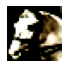

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  3417 true label =  1 6 7 BCNN prediction =  1 6 2 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) animal > medium > bird
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


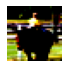

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  3470 true label =  1 6 7 BCNN prediction =  1 5 7 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) animal > pet > horse
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


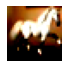

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  3498 true label =  1 6 4 BCNN prediction =  0 6 4 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) transport > medium > deer
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


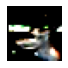

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  3561 true label =  1 6 7 BCNN prediction =  1 5 7 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) animal > pet > horse
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


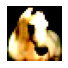

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  3578 true label =  1 6 7 BCNN prediction =  1 6 3 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) animal > medium > cat
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


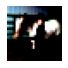

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  3600 true label =  1 6 4 BCNN prediction =  1 4 4 HDCapsNet prediction =  1 5 3
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > reptile > deer
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > cat


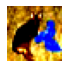

example  3618 true label =  1 6 4 BCNN prediction =  1 6 2 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > medium > bird
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


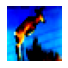

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  3627 true label =  1 6 4 BCNN prediction =  1 5 4 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > pet > deer
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


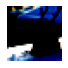

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  3696 true label =  1 6 4 BCNN prediction =  1 5 4 HDCapsNet prediction =  1 3 2
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > pet > deer
HDCapsNet prediction = (Coarse > Medium fine) animal > bird > bird


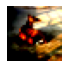

example  3708 true label =  1 6 4 BCNN prediction =  1 4 4 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > reptile > deer
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


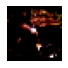

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  3756 true label =  1 6 7 BCNN prediction =  0 2 7 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) transport > road > horse
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


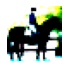

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  3766 true label =  1 6 4 BCNN prediction =  0 6 4 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) transport > medium > deer
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


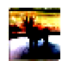

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  3827 true label =  1 6 4 BCNN prediction =  1 5 4 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > pet > deer
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


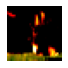

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  3944 true label =  1 6 7 BCNN prediction =  0 6 7 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) transport > medium > horse
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


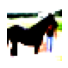

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  3953 true label =  1 6 7 BCNN prediction =  1 6 3 HDCapsNet prediction =  1 5 3
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) animal > medium > cat
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > cat


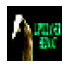

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  3962 true label =  1 6 4 BCNN prediction =  1 5 7 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > pet > horse
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


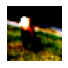

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  3995 true label =  1 6 7 BCNN prediction =  1 5 9 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) animal > pet > truck
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


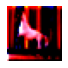

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  4029 true label =  1 6 4 BCNN prediction =  1 5 4 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > pet > deer
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


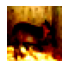

example  4042 true label =  1 6 4 BCNN prediction =  1 0 4 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > sky > deer
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


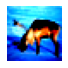

example  4058 true label =  1 6 7 BCNN prediction =  1 5 7 HDCapsNet prediction =  1 5 5
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) animal > pet > horse
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > dog


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


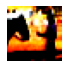

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  4099 true label =  1 6 4 BCNN prediction =  1 5 6 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > pet > frog
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


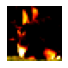

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  4173 true label =  1 6 4 BCNN prediction =  1 6 0 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > medium > airplane
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


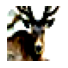

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  4220 true label =  1 6 4 BCNN prediction =  0 6 4 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) transport > medium > deer
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


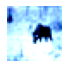

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  4368 true label =  1 6 4 BCNN prediction =  1 5 4 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > pet > deer
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


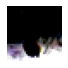

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  4383 true label =  1 6 4 BCNN prediction =  1 6 3 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > medium > cat
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


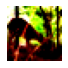

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  4416 true label =  1 6 4 BCNN prediction =  1 3 4 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > bird > deer
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


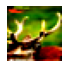

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  4493 true label =  1 6 4 BCNN prediction =  1 6 2 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > medium > bird
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


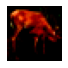

example  4563 true label =  1 6 7 BCNN prediction =  1 5 7 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) animal > pet > horse
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


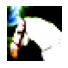

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  4596 true label =  1 6 7 BCNN prediction =  1 6 5 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) animal > medium > dog
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


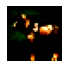

example  4620 true label =  1 6 7 BCNN prediction =  1 5 7 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) animal > pet > horse
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


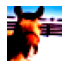

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  4694 true label =  1 6 7 BCNN prediction =  1 6 3 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) animal > medium > cat
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


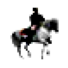

example  4750 true label =  1 6 7 BCNN prediction =  0 0 9 HDCapsNet prediction =  0 2 9
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) transport > sky > truck
HDCapsNet prediction = (Coarse > Medium fine) transport > road > truck


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


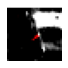

example  4825 true label =  1 6 7 BCNN prediction =  1 3 7 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) animal > bird > horse
HDCapsNet prediction = (Coarse > Medium fine) animal > 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


medium > horse


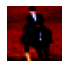

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  4847 true label =  1 6 4 BCNN prediction =  1 5 4 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > pet > deer
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


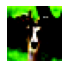

example  4884 true label =  1 6 4 BCNN prediction =  1 5 4 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > pet > deer
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


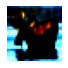

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  4926 true label =  1 6 7 BCNN prediction =  0 5 3 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) transport > pet > cat
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


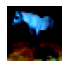

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  4984 true label =  1 6 7 BCNN prediction =  1 5 7 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) animal > pet > horse
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


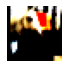

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  5006 true label =  1 6 7 BCNN prediction =  1 6 5 HDCapsNet prediction =  1 3 2
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) animal > medium > dog
HDCapsNet prediction = (Coarse > Medium fine) animal > bird > bird


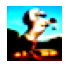

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  5017 true label =  1 6 7 BCNN prediction =  0 6 7 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) transport > medium > horse
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


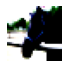

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  5053 true label =  1 6 7 BCNN prediction =  1 6 3 HDCapsNet prediction =  1 5 3
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) animal > medium > cat
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > cat


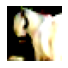

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  5070 true label =  1 6 7 BCNN prediction =  1 5 7 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) animal > pet > horse
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


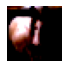

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  5096 true label =  1 6 7 BCNN prediction =  1 6 0 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) animal > medium > airplane
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


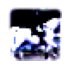

example  5162 true label =  1 6 7 BCNN prediction =  1 6 2 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) animal > medium > bird
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


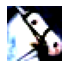

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  5283 true label =  1 6 4 BCNN prediction =  1 3 4 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > bird > deer
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


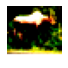

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  5435 true label =  1 6 7 BCNN prediction =  0 6 7 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) transport > medium > horse
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


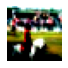

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  5444 true label =  1 6 7 BCNN prediction =  0 6 7 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) transport > medium > horse
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


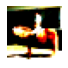

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  5539 true label =  1 6 4 BCNN prediction =  1 6 3 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > medium > cat
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


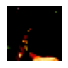

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  5551 true label =  1 6 7 BCNN prediction =  0 6 7 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) transport > medium > horse
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


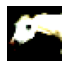

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  5558 true label =  1 6 7 BCNN prediction =  1 5 7 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) animal > pet > horse
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


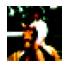

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  5634 true label =  1 6 4 BCNN prediction =  1 3 4 HDCapsNet prediction =  1 5 5
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > bird > deer
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > dog


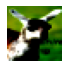

example  5646 true label =  1 6 4 BCNN prediction =  0 1 4 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) transport > water > deer
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


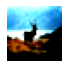

example  5698 true label =  1 6 7 BCNN prediction =  1 5 7 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) animal > pet > horse
HDCapsNet prediction = (Coarse > Medium fine) animal

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 > medium > horse


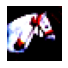

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  5794 true label =  1 6 7 BCNN prediction =  0 0 7 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) transport > sky > horse
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


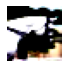

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  5842 true label =  1 6 7 BCNN prediction =  1 5 7 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) animal > pet > horse
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


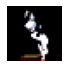

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  5900 true label =  1 6 4 BCNN prediction =  1 5 2 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > pet > bird
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


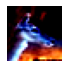

example  5903 true label =  1 6 4 BCNN prediction =  0 5 4 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) transport > pet > deer
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


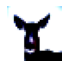

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  5926 true label =  1 6 4 BCNN prediction =  0 6 4 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) transport > medium > deer
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


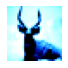

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  6016 true label =  1 6 4 BCNN prediction =  1 4 4 HDCapsNet prediction =  1 4 6
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > reptile > deer
HDCapsNet prediction = (Coarse > Medium fine) animal > reptile > frog


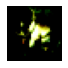

example  6038 true label =  1 6 4 BCNN prediction =  1 6 5 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > medium > dog
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


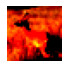

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  6227 true label =  1 6 7 BCNN prediction =  1 6 3 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) animal > medium > cat
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


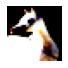

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  6242 true label =  1 6 4 BCNN prediction =  0 6 0 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) transport > medium > airplane
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


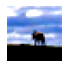

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  6326 true label =  1 6 7 BCNN prediction =  1 6 9 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) animal > medium > truck
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


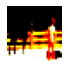

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  6388 true label =  1 6 7 BCNN prediction =  1 5 7 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) animal > pet > horse
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


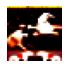

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  6498 true label =  1 6 4 BCNN prediction =  1 6 6 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > medium > frog
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


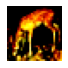

example  6499 true label =  1 6 7 BCNN prediction =  1 5 7 HDCapsNet prediction =  1 5 3
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) animal > pet > horse
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > cat


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


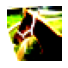

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  6531 true label =  1 6 4 BCNN prediction =  1 6 5 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > medium > dog
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


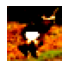

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  6582 true label =  1 6 4 BCNN prediction =  0 6 4 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) transport > medium > deer
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


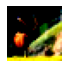

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  6612 true label =  1 6 7 BCNN prediction =  1 5 7 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) animal > pet > horse
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


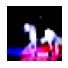

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  6634 true label =  1 6 4 BCNN prediction =  1 5 4 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > pet > deer
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


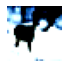

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  6678 true label =  1 6 7 BCNN prediction =  1 3 7 HDCapsNet prediction =  1 3 2
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) animal > bird > horse
HDCapsNet prediction = (Coarse > Medium fine) animal > bird > bird


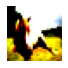

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  6721 true label =  1 6 7 BCNN prediction =  1 3 7 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) animal > bird > horse
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


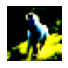

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  6753 true label =  1 6 4 BCNN prediction =  1 1 8 HDCapsNet prediction =  1 3 2
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > water > ship
HDCapsNet prediction = (Coarse > Medium fine) animal > bird > bird


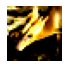

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  6790 true label =  1 6 7 BCNN prediction =  1 6 3 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) animal > medium > cat
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


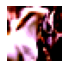

example  6822 true label =  1 6 4 BCNN prediction =  1 3 4 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > bird > deer
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


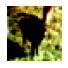

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  6958 true label =  1 6 7 BCNN prediction =  1 0 7 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) animal > sky > horse
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


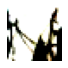

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  6977 true label =  1 6 7 BCNN prediction =  1 6 5 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) animal > medium > dog
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


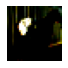

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  7040 true label =  1 6 7 BCNN prediction =  0 6 0 HDCapsNet prediction =  0 0 0
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) transport > medium > airplane
HDCapsNet prediction = (Coarse > Medium fine) transport > sky > airplane


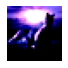

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  7041 true label =  1 6 4 BCNN prediction =  1 6 0 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > medium > airplane
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


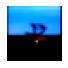

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  7081 true label =  1 6 4 BCNN prediction =  1 3 4 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > bird > deer
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


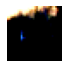

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  7120 true label =  1 6 7 BCNN prediction =  1 5 7 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) animal > pet > horse
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


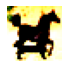

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  7195 true label =  1 6 7 BCNN prediction =  1 3 7 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) animal > bird > horse
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


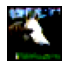

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  7343 true label =  1 6 7 BCNN prediction =  1 5 2 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) animal > pet > bird
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


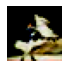

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  7408 true label =  1 6 4 BCNN prediction =  1 6 2 HDCapsNet prediction =  1 5 5
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > medium > bird
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > dog


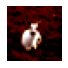

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  7443 true label =  1 6 7 BCNN prediction =  1 5 7 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) animal > pet > horse
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


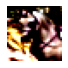

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  7507 true label =  1 6 7 BCNN prediction =  1 5 7 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) animal > pet > horse
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


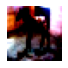

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  7520 true label =  1 6 4 BCNN prediction =  1 5 4 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > pet > deer
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


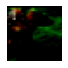

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  7628 true label =  1 6 4 BCNN prediction =  1 5 4 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > pet > deer
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


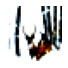

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  7766 true label =  1 6 4 BCNN prediction =  1 4 4 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > reptile > deer
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


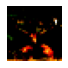

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  7848 true label =  1 6 4 BCNN prediction =  1 3 4 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > bird > deer
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


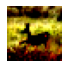

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  7857 true label =  1 6 4 BCNN prediction =  1 6 3 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > medium > cat
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


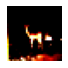

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  7867 true label =  1 6 4 BCNN prediction =  1 3 6 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > bird > frog
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


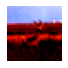

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  7916 true label =  1 6 4 BCNN prediction =  1 3 4 HDCapsNet prediction =  1 3 2
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > bird > deer
HDCapsNet prediction = (Coarse > Medium fine) animal > bird > bird


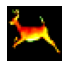

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  8003 true label =  1 6 4 BCNN prediction =  1 5 4 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > pet > deer
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


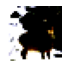

example  8016 true label =  1 6 4 BCNN prediction =  1 5 4 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > pet > deer
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


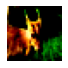

example  8092 true label =  1 6 4 BCNN prediction =  0 6 4 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) transport > medium > deer
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


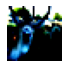

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  8103 true label =  1 6 7 BCNN prediction =  1 5 7 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) animal > pet > horse
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


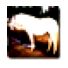

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  8118 true label =  1 6 4 BCNN prediction =  0 6 4 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) transport > medium > deer
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


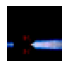

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  8180 true label =  1 6 4 BCNN prediction =  1 3 4 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > bird > deer
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


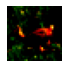

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  8344 true label =  1 6 7 BCNN prediction =  1 6 2 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) animal > medium > bird
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


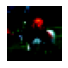

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  8364 true label =  1 6 7 BCNN prediction =  0 0 7 HDCapsNet prediction =  1 3 2
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) transport > sky > horse
HDCapsNet prediction = (Coarse > Medium fine) animal > bird > bird


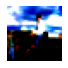

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  8370 true label =  1 6 4 BCNN prediction =  1 4 4 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > reptile > deer
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


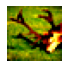

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  8381 true label =  1 6 4 BCNN prediction =  1 5 4 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > pet > deer
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


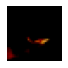

example  8448 true label =  1 6 4 BCNN prediction =  1 6 3 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > medium > cat
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


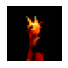

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  8553 true label =  1 6 7 BCNN prediction =  1 5 7 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) animal > pet > horse
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


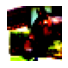

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  8566 true label =  1 6 4 BCNN prediction =  0 6 4 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) transport > medium > deer
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


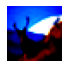

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  8699 true label =  1 6 4 BCNN prediction =  1 5 6 HDCapsNet prediction =  1 5 5
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > pet > frog
HDCapsNet prediction = (Coarse > Medium fine) animal > pet > dog


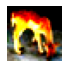

example  8779 true label =  1 6 7 BCNN prediction =  1 5 7 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) animal > pet > horse
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


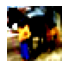

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  8836 true label =  1 6 4 BCNN prediction =  1 3 4 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > bird > deer
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


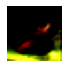

example  8854 true label =  1 6 4 BCNN prediction =  0 3 2 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) transport > bird > bird
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


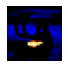

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  8868 true label =  1 6 4 BCNN prediction =  1 6 6 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > medium > frog
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


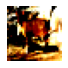

example  8898 true label =  1 6 7 BCNN prediction =  1 0 2 HDCapsNet prediction =  0 0 0
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) animal > sky > bird
HDCapsNet prediction = (Coarse > Medium fine) transport > sky > airplane


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


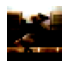

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  8918 true label =  1 6 7 BCNN prediction =  0 6 7 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) transport > medium > horse
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


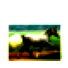

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  8947 true label =  1 6 4 BCNN prediction =  1 6 2 HDCapsNet prediction =  1 3 2
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > medium > bird
HDCapsNet prediction = (Coarse > Medium fine) animal > bird > bird


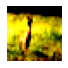

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  9071 true label =  1 6 7 BCNN prediction =  1 6 3 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) animal > medium > cat
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


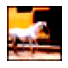

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  9149 true label =  1 6 7 BCNN prediction =  1 2 7 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) animal > road > horse
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


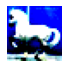

example  9385 true label =  1 6 7 BCNN prediction =  1 4 2 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) animal > reptile > bird
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


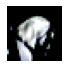

example  9468 true label =  1 6 7 BCNN prediction =  1 5 7 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 animal > pet > horse
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


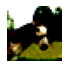

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  9549 true label =  1 6 4 BCNN prediction =  1 6 5 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > medium > dog
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


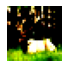

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  9635 true label =  1 6 7 BCNN prediction =  1 6 5 HDCapsNet prediction =  1 4 6
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) animal > medium > dog
HDCapsNet prediction = (Coarse > Medium fine) animal > reptile > frog


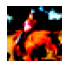

example  9710 true label =  1 6 7 BCNN prediction =  1 5 7 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) animal > pet > horse
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


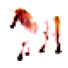

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  9780 true label =  1 6 4 BCNN prediction =  1 6 5 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > medium > dog
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


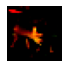

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  9899 true label =  1 6 7 BCNN prediction =  0 6 7 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) transport > medium > horse
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


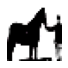

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  9923 true label =  1 6 7 BCNN prediction =  1 6 6 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) animal > medium > frog
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


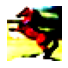

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  9924 true label =  1 6 4 BCNN prediction =  0 5 9 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) transport > pet > truck
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


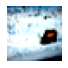

example  9942 true label =  1 6 7 BCNN prediction =  0 6 7 HDCapsNet prediction =  1 6 7
true label = (Coarse > Medium fine) animal > medium > horse
BCNN prediction = (Coarse > Medium fine) transport > medium > horse
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > horse


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


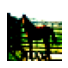

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example  9972 true label =  1 6 4 BCNN prediction =  1 6 3 HDCapsNet prediction =  1 6 4
true label = (Coarse > Medium fine) animal > medium > deer
BCNN prediction = (Coarse > Medium fine) animal > medium > cat
HDCapsNet prediction = (Coarse > Medium fine) animal > medium > deer


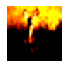

In [32]:
## Check the not consistent examples of bcnn that are consistent in hd
for i in bcnn_not_consistent.keys():
    if i in hd_consistent.keys():
        
        if true_label[2][i] == 4 or true_label[2][i] == 7: # only for true label fine = 2 or 9
        # if true_label[2][i] == 4: # only for true label fine = 2
            # wrong prediction of hdcapsnet
#             if np.argmax(HDCapsNet_predictions[0][i]) == true_label[0][i] and np.argmax(HDCapsNet_predictions[1][i]) == true_label[1][i] and  np.argmax(HDCapsNet_predictions[2][i]) != true_label[2][i]:
                print('example ', i, 'true label = ', true_label[0][i], true_label[1][i], true_label[2][i],
                    'BCNN prediction = ', np.argmax(BCNN_predictions[0][i]), np.argmax(BCNN_predictions[1][i]), np.argmax(BCNN_predictions[2][i]),
                    'HDCapsNet prediction = ', np.argmax(HDCapsNet_predictions[0][i]), np.argmax(HDCapsNet_predictions[1][i]), np.argmax(HDCapsNet_predictions[2][i])
                    )
                # print true label names
                print('true label = (Coarse > Medium fine)',label_names_coarse[true_label[0][i]], '>', label_names_medium[true_label[1][i]],'>' ,label_names_fine[true_label[2][i]])
                # print bcnn prediction names
                print('BCNN prediction = (Coarse > Medium fine)', label_names_coarse[np.argmax(BCNN_predictions[0][i])], '>',label_names_medium[np.argmax(BCNN_predictions[1][i])], '>',label_names_fine[np.argmax(BCNN_predictions[2][i])])
                # print hd prediction names
                print('HDCapsNet prediction = (Coarse > Medium fine)', label_names_coarse[np.argmax(HDCapsNet_predictions[0][i])], '>',label_names_medium[np.argmax(HDCapsNet_predictions[1][i])], '>',label_names_fine[np.argmax(HDCapsNet_predictions[2][i])])
                plt.figure(figsize = (1,1))
                plt.imshow(dataset['x_test'][i])
                plt.axis('off')
                plt.show()